### ES 155 Final Project - Xu Si
# Moving Behavior Detection and People Recognition

In [429]:
import numpy as np
import scipy as sp
from scipy import signal
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import sklearn
import peakutils
from peakutils.plot import plot as pplot
import cPickle as pickle
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
plotly.tools.set_credentials_file(username='Sophie301', api_key='huVoyZ9GRXaWsHXTmvj6')

%matplotlib inline

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

> ## Project description

### Motivation

People are walking all the time. If you pay attention to the patterns people move, you will notice the similarity among people when they walk at plain ground, run, go upstairs, downstairs etc. Let us name them moving behaviors. Also, there will be difference of moving behaviors between every two individuals.

To me, it would be interesting to extract the average patterns from people’s moving behaviors and detect whether they are walking, running, going upstairs etc. When focusing on the difference instead of similarity, I will also try to recognize different people using the individual patterns.

### Benefits

If we are able to do moving behavior detection, we can collect information of people's daily activities, which can help promote healthy living. People recognition is also of good use in many aspects such as identity authentication.

Practically, the wearable device can further be produced as a chip embedded in shoes, easier to equip and manage.

### Goals
- Extract **typical patterns** of different moving behaviors (walk, run, go upstairs, etc.) from the acceleration signals of 6 different people.
- Moving Behaviors **classfication**. 
- People **recognition** using the moving signals from the 6 different people.

### Data Colleciton

Device: Empitica4 Band

Find 6 random people, put the band on their right ankles, collect continuous acceleration data in three directions (x, y, z) when they go upstairs, run upstairs, go downstairs, run downstairs, walk, walk fast and run. Each moving behavior lasts for at least 15s.

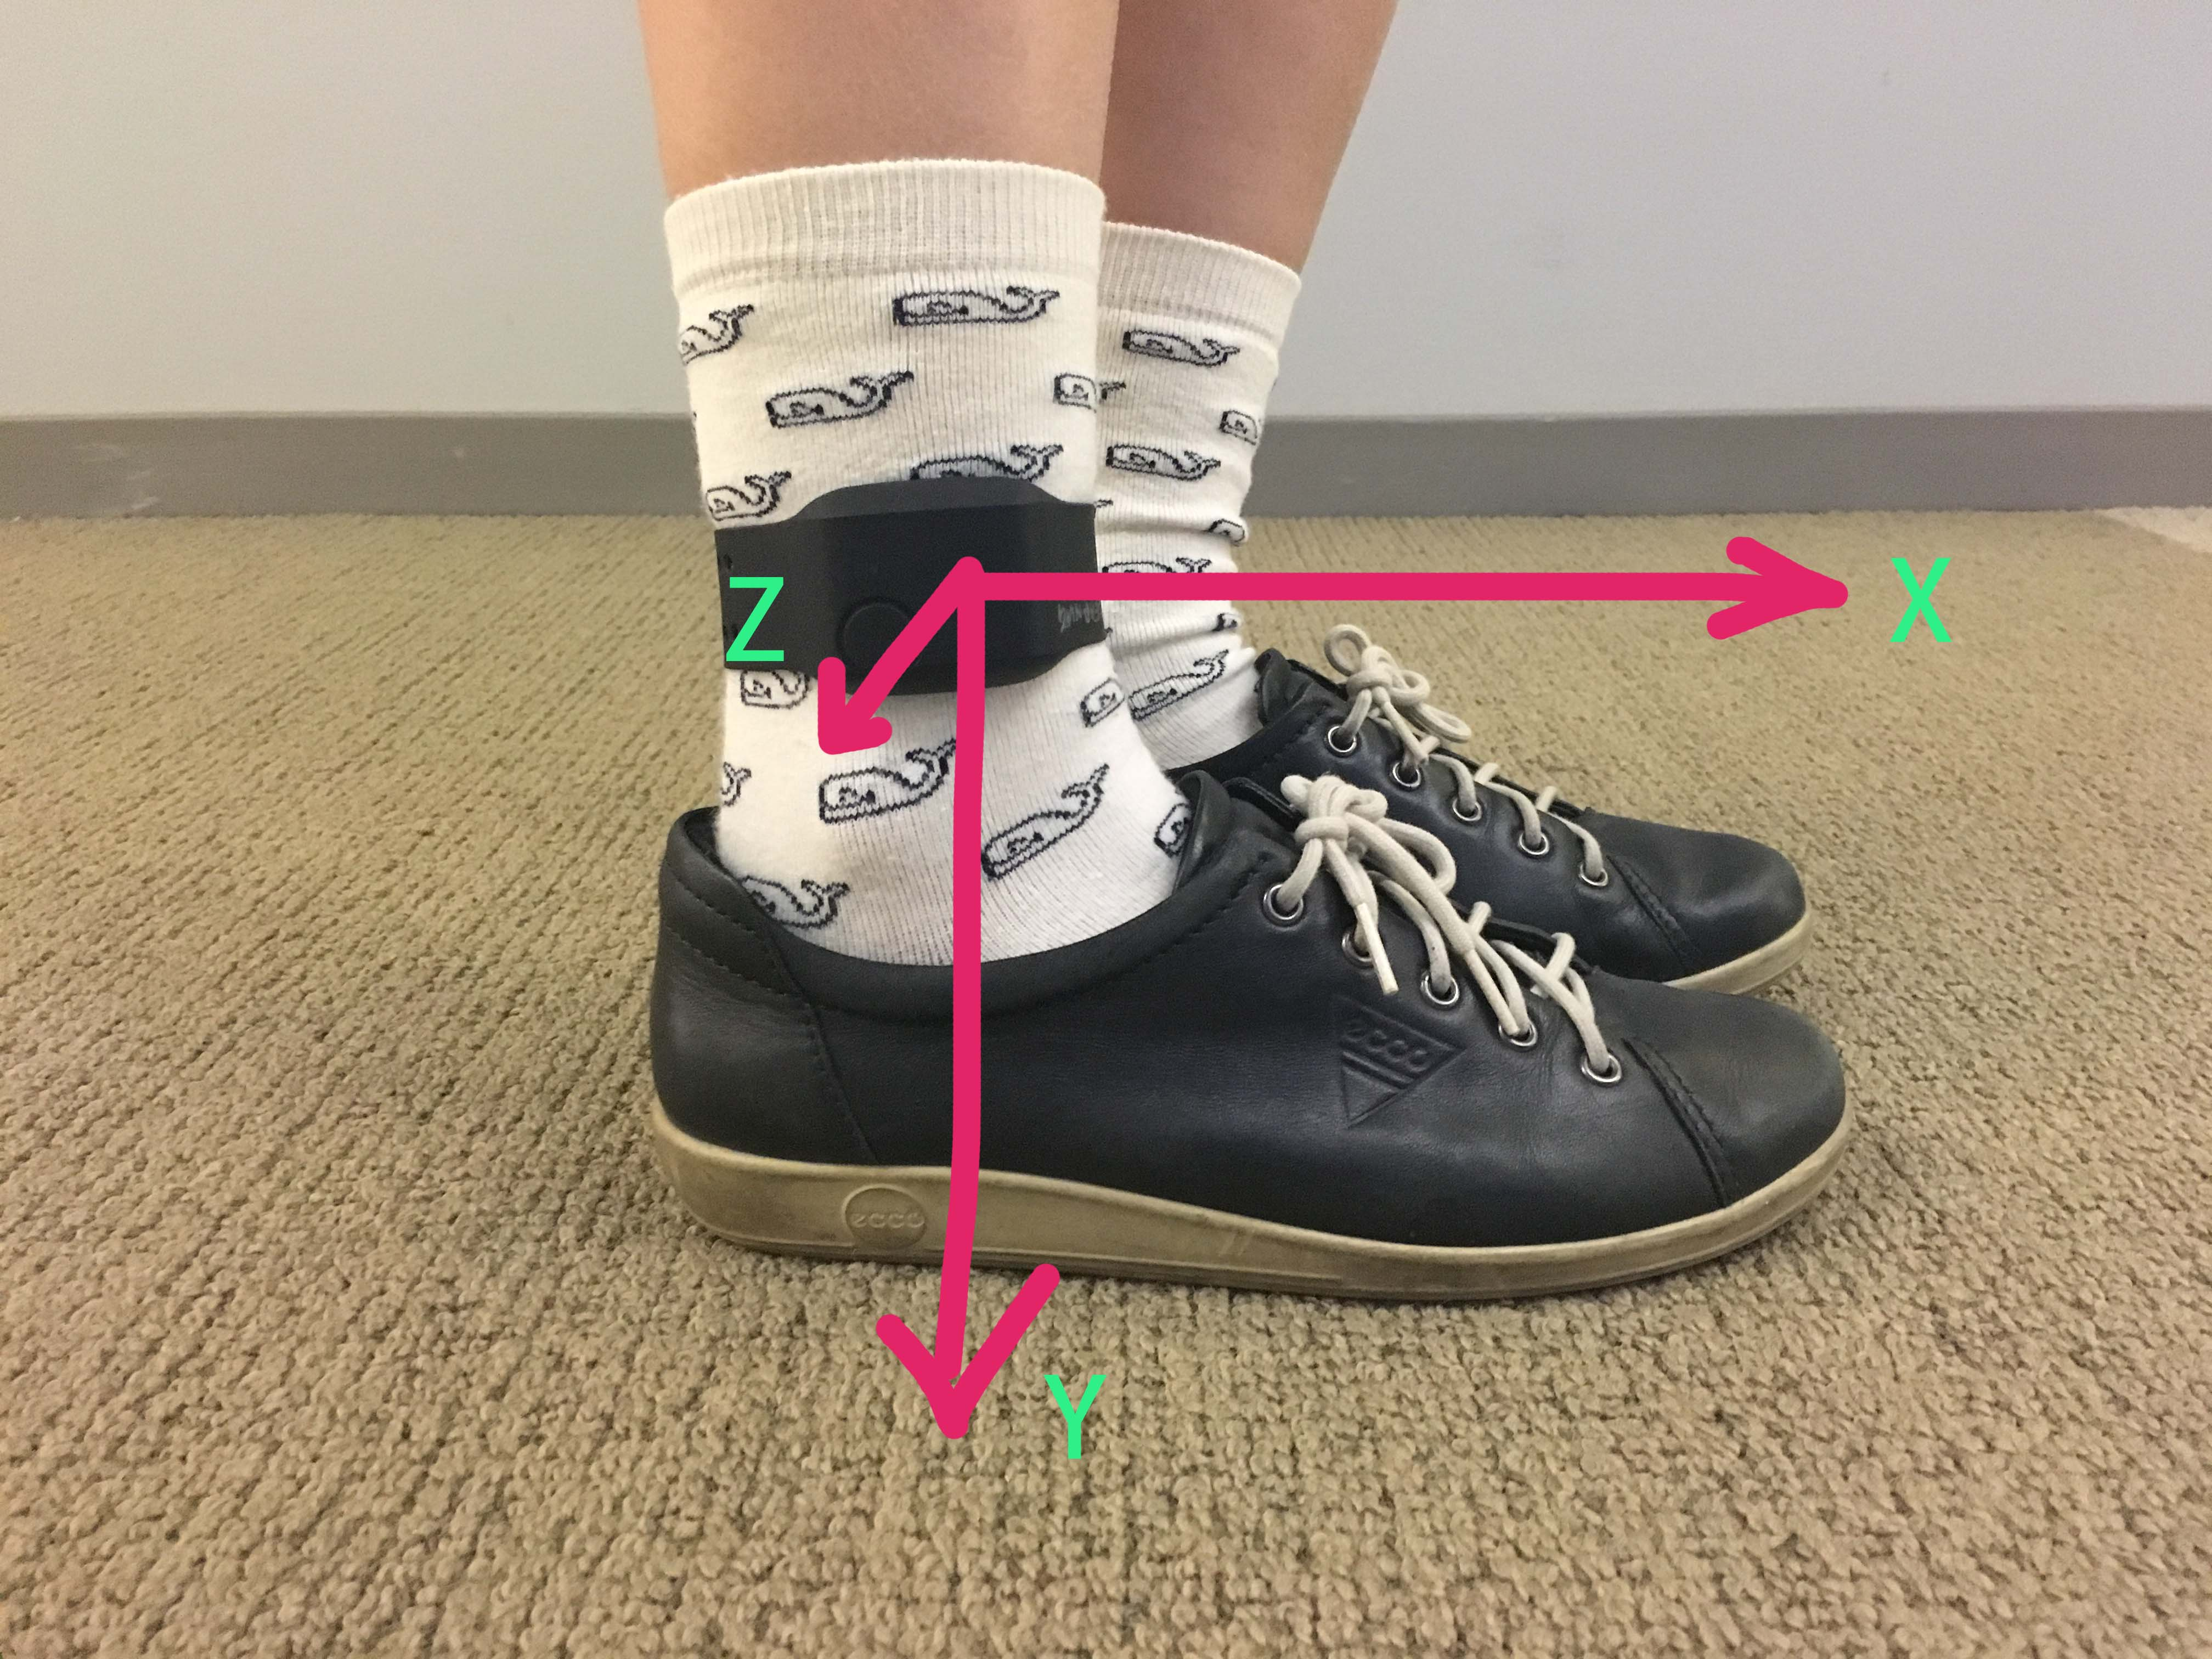

In [4]:
Image(filename='device2.jpg',width=500)

>## Data

Here we have a look at the my acceleration data (magnitude).

In [341]:
#Read CSV file and have a look at the acceleration data
df = pd.read_csv("Xu/ACC.csv", delimiter=",")
df.head()

1478991894.000000   1478991894.000000   1478991894.000000.1
0               32.0                32.0                  32.0
1                8.0                63.0                   7.0
2                7.0                63.0                   7.0
3                7.0                63.0                   7.0
4                7.0                63.0                   7.0

In [695]:
#Define a class to learn features
class Features:
    def __init__(self,up,down,walk,run):
        self.up = up
        self.down = down
        self.walk = walk
        self.run = run
        self.y1 = np.empty(self.up.shape[0])
        self.y1.fill(1)
        self.y2 = np.empty(self.down.shape[0])
        self.y2.fill(2)
        self.y3 = np.empty(self.walk.shape[0])
        self.y3.fill(3)
        self.y4 = np.empty(self.run.shape[0])
        self.y4.fill(4)
        self.y = np.concatenate((self.y1,self.y2,self.y3,self.y4))
        return 
        
        
    def learn(self,up,down,walk,run):
        self.up = np.concatenate((self.up,up))
        self.down = np.concatenate((self.down,down))
        self.walk = np.concatenate((self.walk,walk))
        self.run = np.concatenate((self.run,run))
        
        self.y1 = np.empty(self.up.shape[0])
        self.y1.fill(1)
        self.y2 = np.empty(self.down.shape[0])
        self.y2.fill(2)
        self.y3 = np.empty(self.walk.shape[0])
        self.y3.fill(3)
        self.y4 = np.empty(self.run.shape[0])
        self.y4.fill(4)
        
        self.x = np.concatenate((self.up,self.down, self.walk, self.run))
        self.y = np.concatenate((self.y1,self.y2,self.y3,self.y4))
        
        return self.x, self.y

In [345]:
#Define a class to process and visualize every moving behavior
class Processing:
    
    #initialize one moving behavior: remove mean, set length, time period, x,y,z, and magnitude
    def __init__(self, data):
        #self.data = self
        self.data = data
        #remove mean
        self.x = (data[[0]] - data[[0]].values.mean()).values[:,0]
        self.y = (data[[1]] - data[[1]].values.mean()).values[:,0]
        self.z = (data[[2]] - data[[2]].values.mean()).values[:,0]
        m = (np.sqrt((data ** 2).sum(axis = 1))).values
        m_mean = m.mean()
        self.m = m - m_mean
        self.length = data.shape[0]
        self.time = self.length / 32.
        self.t = np.linspace(0, self.time, self.length) #define time scale
        print "Total Samples: ", self.length
        
    #a function to visualize acceleration data from one direction, peaks are optional
    def Plot_data(self, direction, dir_str, title, with_peaks = False, peaks = []):

        #define style for plot
        title_font = {'fontname':'Arial', 'size':'20'}
        axis_font = {'fontname':'Arial', 'size':'15'}

        fig, ax = plt.subplots(1,1,figsize = (20,5))
        #if true show peaks in the plot
        if (with_peaks):
            pplot(self.t, direction, peaks)
            ax.set_title('Peaks')
            ax.set_xlabel("time/s", **axis_font)
            ax.set_ylabel("ACC " + dir_str, **axis_font)
        
        #otherwise, just show acceleration data
        else:
            #plot
            ax.plot(self.t,direction)
            ax.set_xticks(np.arange(min(self.t), max(self.t), 10.0))
            ax.set_xlabel("time/s", **axis_font)
            ax.set_ylabel("ACC " + dir_str, **axis_font)
            ax.set_title(title, **title_font)
            
        return ax
        
    #a function to find peaks 
    def Peaks(self, direction, dir_str, thres, min_dist, plot = True):
        
        #define style for plot
        title_font = {'fontname':'Arial', 'size':'20'}
        axis_font = {'fontname':'Arial', 'size':'15'}
        
        indexes = peakutils.indexes(-direction, thres=thres, min_dist=min_dist)
        if plot:
            plt.figure(figsize=(20,5))
            pplot(self.t, direction, indexes[1:-1]) #skip the first and the last peaks
            plt.title('Peaks')
            plt.xlabel("time/s", **axis_font)
            plt.ylabel("ACC " + dir_str, **axis_font)

        return indexes[1:-1] 
        
    #Segment data by time
    def Clip(self, interval):

        start_time = interval[0]
        end_time = interval[1]
        start_sample = int(start_time/float(self.time) * self.length)
        end_sample = int(end_time/float(self.time) * self.length)
        
        return self.data.iloc[start_sample:end_sample,:]
    
    #plot segmented (repetitive) data and average feature
    def Segment_Feature(self, direction, buffer_size, peaks):
        
        #line up repetitive segments
        window_size = 2*buffer_size+1
        steps = np.zeros((len(peaks),window_size))
        for i,index in enumerate(peaks):
            temp = np.arange(index-buffer_size,index+buffer_size+1)
            steps[i,:] = direction[temp]

        steps = np.transpose(steps)
        print steps.shape

        
        fig, ax = plt.subplots(1,2,figsize=(10,3))
        
        #plot the repetitive segments
        t = np.linspace(0,window_size/32.0,window_size)
        mean_step = np.mean(steps,axis = 1)
        ax[0].plot(t.reshape(-1,1),steps,color = 'b')
        ax[0].plot(t.reshape(-1,1),mean_step,color = 'r',linewidth = 4, label = "Mean Segment")
        ax[0].set_title("Plot of All Segments")
        ax[0].set_xlabel("t/s")
        ax[0].set_ylabel("Magnitude")
        ax[0].legend()
        
        #plot extracted feature
        off_set = np.min(mean_step) 
        mean_step_off_set = mean_step - off_set #move signal above zero
        top = np.max(mean_step_off_set) 
        feature = mean_step_off_set/float(top) #standardize it to have max magnitude 1
        
        
        ax[1].plot(t.reshape(-1,1),feature - feature.mean()) # remove feature mean for matched filter
        ax[1].set_title("Average Feature")
        #ax[1].plot(t.reshape(-1,1),np.flipud(feature))
        
        
        #return np.flipud(feature - feature.mean()), np.transpose(steps)
        return np.flipud(feature), np.flipud(feature - feature.mean()), np.transpose(steps)
    
    def extract_features(self,go_upstairs_normal,go_downstairs_normal,walking_normal,running):
        #going up stairs feature
        peaks_1 = go_upstairs_normal.Peaks(go_upstairs_normal.m,"M", 0.3, 20, plot = False)
        go_upstairs_normal_feature1, go_upstairs_normal_feature2, go_upstairs_normal_set = go_upstairs_normal.Segment_Feature(go_upstairs_normal.m,14,peaks_1)
        peaks_2 = go_downstairs_normal.Peaks(go_downstairs_normal.m,"M", 0.3, 20,plot = False)
        go_downstairs_normal_feature1,go_downstairs_normal_feature2,go_downstairs_normal_set = go_downstairs_normal.Segment_Feature(go_downstairs_normal.m,14,peaks_2)
        peaks_3 = walking_normal.Peaks(walking_normal.m,"Magnitude", 0.3, 20, plot = False )
        walking_normal_feature1, walking_normal_feature2,walking_normal_set = walking_normal.Segment_Feature(walking_normal.m,14,peaks_3)
        peaks_4 = running.Peaks(running.m, "Magnitude",0.3, 20, plot = False )
        running_feature1,running_feature2,running_set = running.Segment_Feature(running.m,14,peaks_4)
        
        features1 = [go_upstairs_normal_feature1,go_downstairs_normal_feature1,walking_normal_feature1,running_feature1]
        features2 = [go_upstairs_normal_feature2,go_downstairs_normal_feature2,walking_normal_feature2,running_feature2]
        features_set = [go_upstairs_normal_set,go_downstairs_normal_set,walking_normal_set,running_set]
        return features1, features2, features_set
        
    #delete some part of the signal (e.g. noise)
    #start: start time in seconds
    #end: end time in seconds
    def delete(self, start, end):
        n_start = int(float(start)/self.time * self.length)
        n_end = int(float(end)/self.time * self.length)
       
        return self.data.drop(self.data.index[n_start:n_end])
    def save(self, filename):
        self.data.to_csv(filename, sep = ",", index_label = False )

Total Samples:  7315


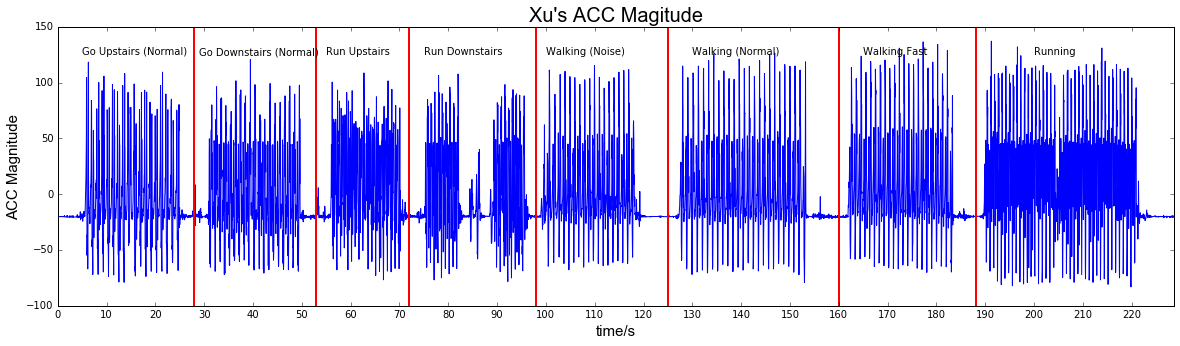

In [346]:
#--------------------------
#Plot the ACC magnitude data by time
#--------------------------

#read in the whole data
xu = Processing(df)
ax = xu.Plot_data(xu.m,"Magnitude", "Xu's ACC Magitude")
ax.plot([28, 28], [-100, 150], 'r-',lw=2)
ax.text(5, 125, 'Go Upstairs (Normal)')

ax.plot([53, 53], [-100, 150], 'r-',lw=2)
ax.text(29, 125, 'Go Downstairs (Normal)')

ax.plot([72, 72], [-100, 150], 'r-',lw=2)
ax.text(55, 125, 'Run Upstairs')

ax.plot([98, 98], [-100, 150], 'r-',lw=2)
ax.text(75, 125, 'Run Downstairs')

ax.plot([125, 125], [-100, 150], 'r-',lw=2)
ax.text(100, 125, 'Walking (Noise)')

ax.plot([160, 160], [-100, 150], 'r-',lw=2)
ax.text(130, 125, 'Walking (Normal)')

ax.plot([188, 188], [-100, 150], 'r-',lw=2)
ax.text(165, 125, 'Walking Fast')
ax.text(200, 125, 'Running')

>## Assumptions and Decision Making

### 1. Segmentation   

- Detect Peaks  

After many attempts, I find that,generally, every moving behavior lasts for about 1s. With the sampling frequency being 32Hz, I choose every segment to be **29 samples** by first getting the peaks and then take 14 samples both from the left and the right of the peaks. I also assume that 29 samples apply to different people.

At first, I used **peak finders** to approximate every peak but it produced too much uncertainty. Later, I tried to use **convolusion** to repetatively find the matched segments, again it would not be the most ideal way to segment data since real segments may vary in length. **Manual selection** is accurate but really tedious and time-consuming. 

At last, I find a good way to segment the data: instead of finding positive peaks, I use peak finder on the flipped data (x -> -x) to **find negtive peaks**. Because for the repetitive signals, negtive peaks are unique among people while positvie ones may vary in person. Also, it is really good to **align behaviors** among people. 

Here is an example of the last segmentation methods applied to my going upstairs signals.

**Negtive Peak finders**

(29, 18)


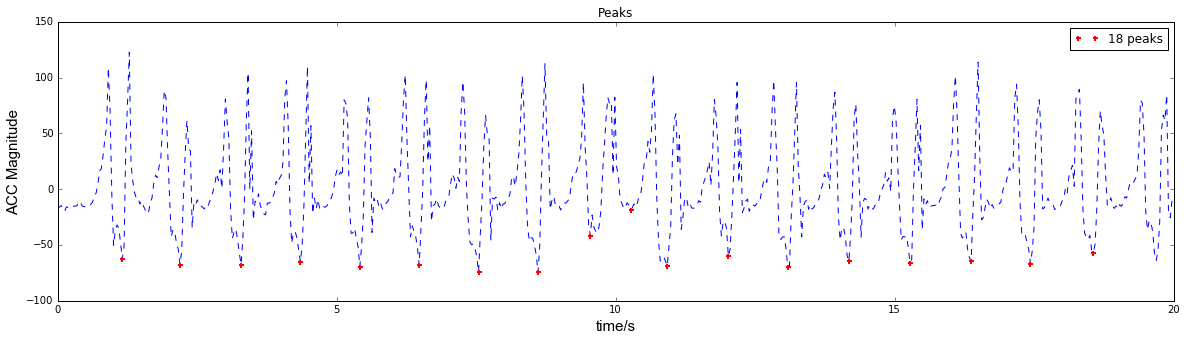

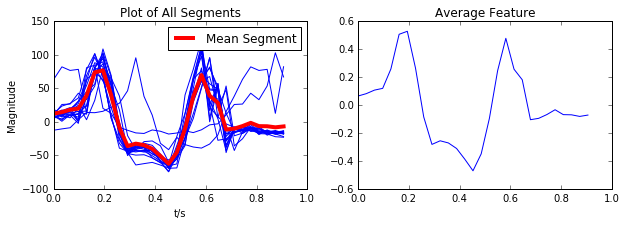

In [333]:
#Negtive Peak finders
peaks = go_upstairs_normal.Peaks(go_upstairs_normal.m,"M", 0.5, 20,plot = 0 )
go_upstairs_normal.Plot_data(go_upstairs_normal.m,"Magnitude", "Going Upstairs (Normal)",with_peaks=True, peaks = peaks)
go_upstairs_normal_feature1,go_upstairs_normal_feature2, go_upstairs_normal_set = go_upstairs_normal.Segment_Feature(go_upstairs_normal.m,14,peaks)

### 2. X,Y,Z or Magnitude?  

There is limitation in acquiring acceleration data. In my experiments, the acc data from x and y directions excess band range (-2g,2g) and Z direction is not very much related to moving features. The magnitude $m = \sqrt {x^2 + y^2 + z^2}$ is used for all the features extraction.

Here is how it looks:

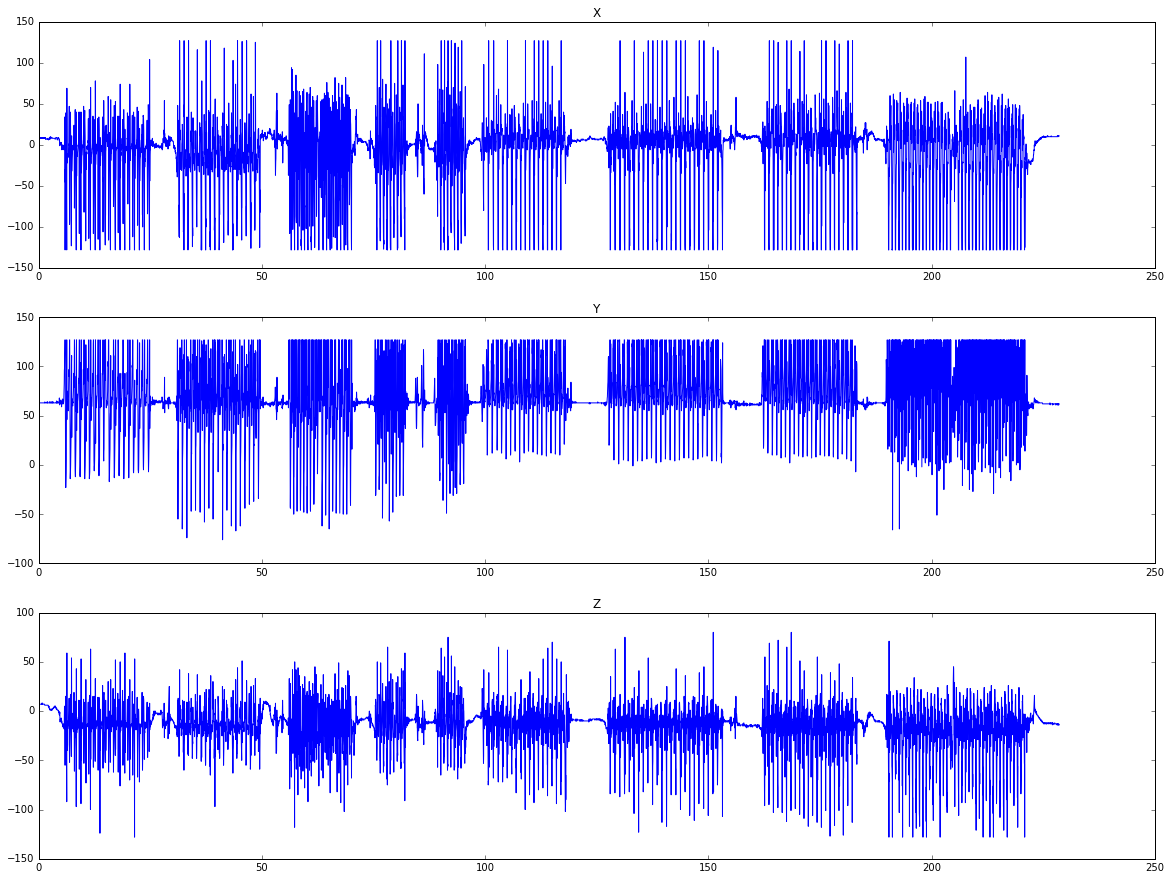

In [166]:
data = pd.read_csv("Xu/ACC.csv", delimiter=",")
data.head()
n = data.shape[0]
t = np.linspace(0,n/32.,n)
acc = [data[[0]].values[:,0],data[[1]].values[:,0],data[[2]].values[:,0]]
titles = ["X","Y","Z"]
fig, ax = plt.subplots(3,1,figsize = (20,15))
for i in range(3):
    ax[i].plot(t,acc[i])
    ax[i].set_title(titles[i])

>## Segment my ACC data by moving behavior

- Going Upstairs (Normal)

Total Samples:  640
(29, 17)


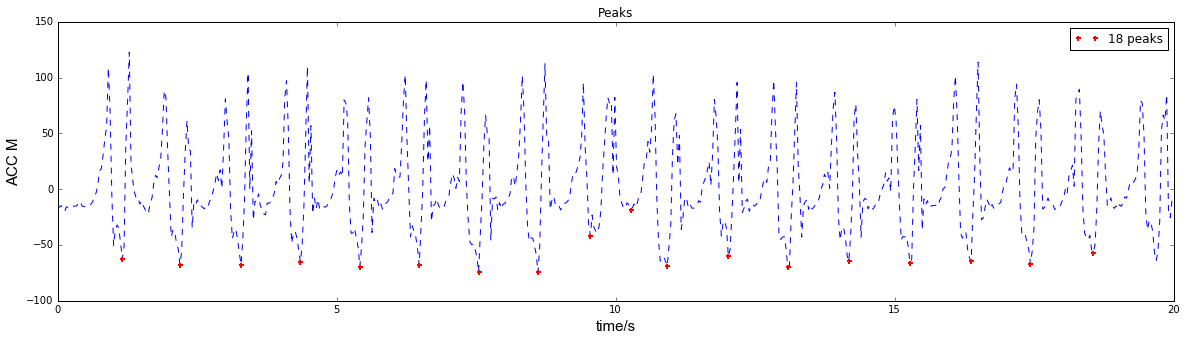

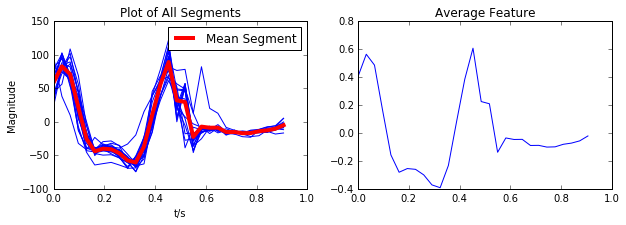

In [701]:
go_upstairs_normal = Processing(xu.Clip([5, 25]))
#go_upstairs_normal.Plot_data(go_upstairs_normal.z,"Z", "Going Upstairs (Normal)")
peaks = go_upstairs_normal.Peaks(go_upstairs_normal.m,"M", 0.3, 20 )
#go_upstairs_normal.Plot_data(go_upstairs_normal.m,"Magnitude", "Going Upstairs (Normal)",with_peaks=True, peaks = peaks)
go_upstairs_normal_feature1,go_upstairs_normal_feature2, go_upstairs_normal_set = go_upstairs_normal.Segment_Feature(go_upstairs_normal.m,14,new_peaks)

- Going Downstairs (Normal)

Total Samples:  640
(29, 18)


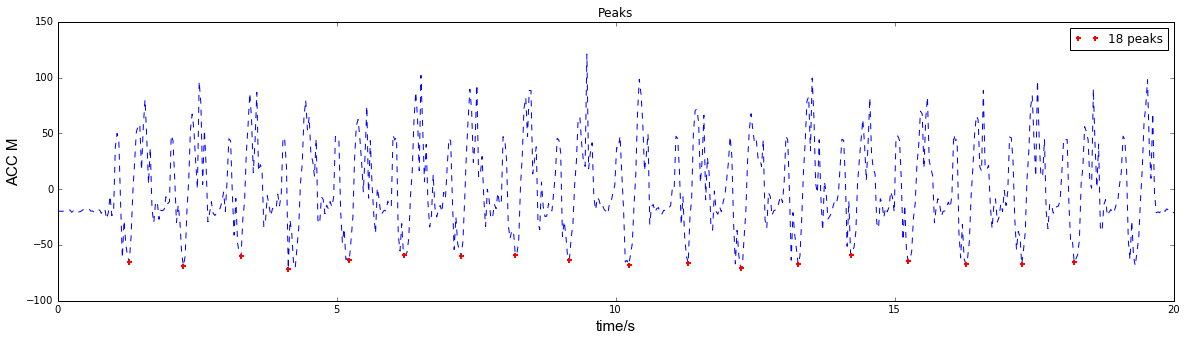

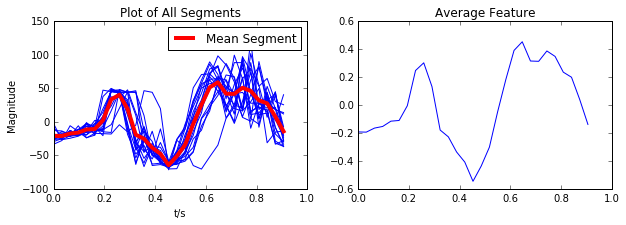

In [349]:
go_downstairs_normal = Processing(xu.Clip([30, 50]))
#go_downstairs_normal.Plot_data(go_downstairs_normal.m,"Magnitude","Going Downstairs (Normal)")
peaks = go_downstairs_normal.Peaks(go_downstairs_normal.m,"M", 0.3, 20 )
#go_downstairs_normal.Plot_data(go_downstairs_normal.m,"Magnitude","Going Downstairs (Normal)",with_peaks=True, peaks = peaks)
go_downstairs_normal_feature1,go_downstairs_normal_feature2,go_downstairs_normal_set = go_downstairs_normal.Segment_Feature(go_downstairs_normal.m,14,peaks)

- Walking (Normal)

Total Samples:  640
(29, 18)


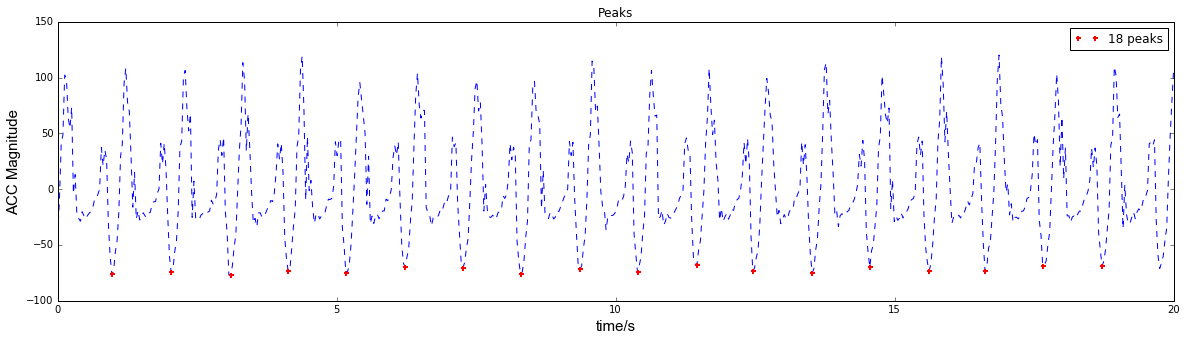

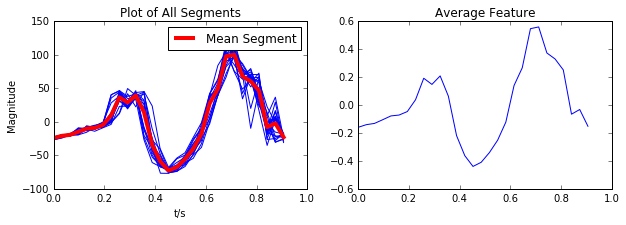

In [337]:
walking_normal = Processing(xu.Clip([130, 150]))
#walking_normal.Plot_data(walking_normal.m,"Magnitude","Walking (Normal)")
peaks = walking_normal.Peaks(walking_normal.m,"Magnitude", 0.3, 20 )
#walking_normal.Plot_data(walking_normal.m,"Magnitude","Walking (Normal)",with_peaks=True, peaks = peaks)
walking_normal_feature1,walking_normal_feature2,walking_normal_set = walking_normal.Segment_Feature(walking_normal.m,14,peaks)

- Running

Total Samples:  960
(29, 37)


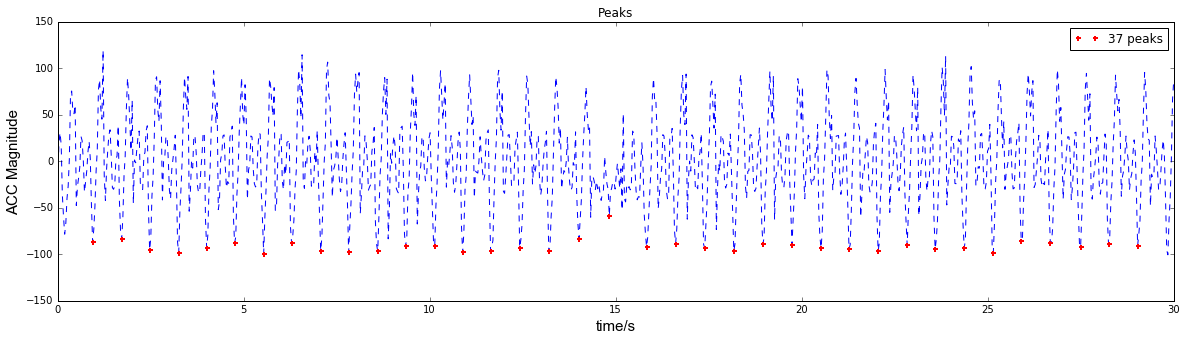

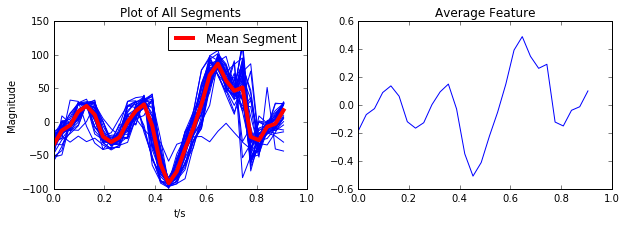

In [338]:
running = Processing(xu.Clip([190, 220]))
#running.Plot_data(running.m,"Magnitude","Running")
peaks = running.Peaks(running.m, "Magnitude",0.3, 20 )
#running.Plot_data(running.m,"Magnitude","Running",with_peaks=True, peaks = peaks)
running_feature1,running_feature2,running_set = running.Segment_Feature(running.m,14,peaks)

- All features (Go Upstairs, Go Downstairs, Walk and Run)

(29, 18)
(29, 18)
(29, 18)
(29, 37)


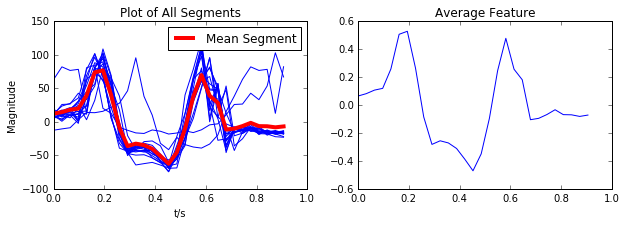

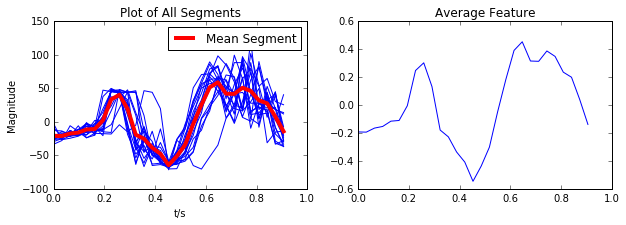

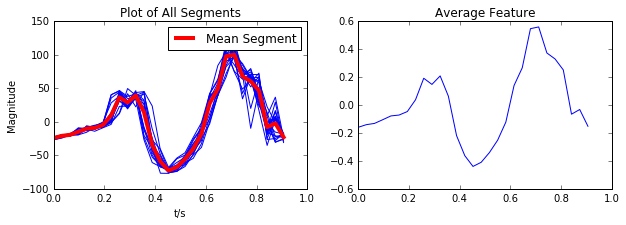

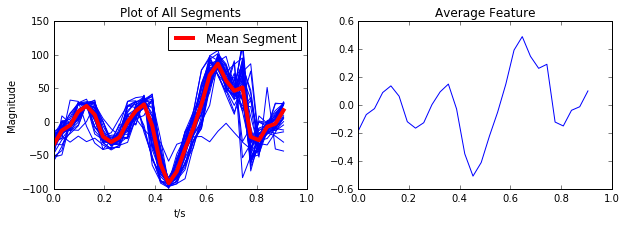

In [347]:
xu_features1, xu_features2, xu_features_set = xu.extract_features(go_upstairs_normal,go_downstairs_normal,walking_normal,running)

>## Do matched filter using the average features

Matched filter is a method to find matched patterns in a long signal. Here we borrow the ideas from matched filter. 

- Convolute a single feature A (flipped right to left) with the whole signal
- Convolute another feature B (flipped right to left) with the whole signal 
- If A produces higher magnitude than B, then A better matches with the signal. 

Below, I convolute my whole signal with 4 extracted features of going upstairs, going downstairs, walking and running. And then compare the convolution magnitude vertically to find the one with highest magnitude. 

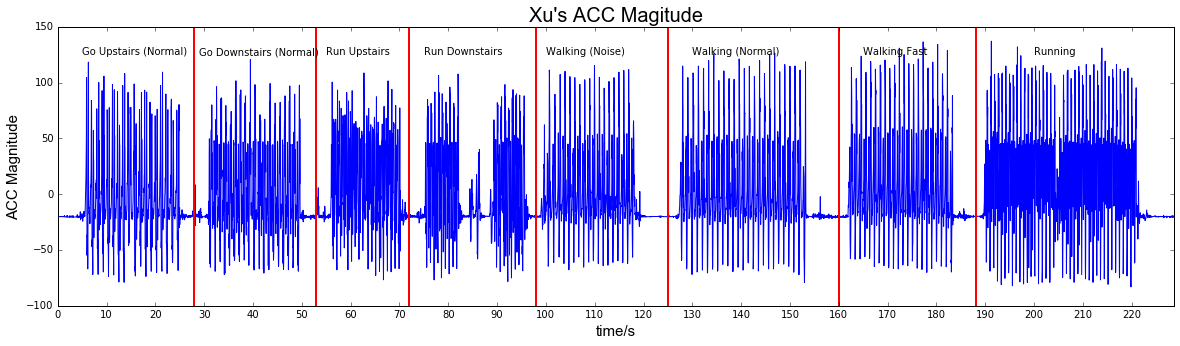

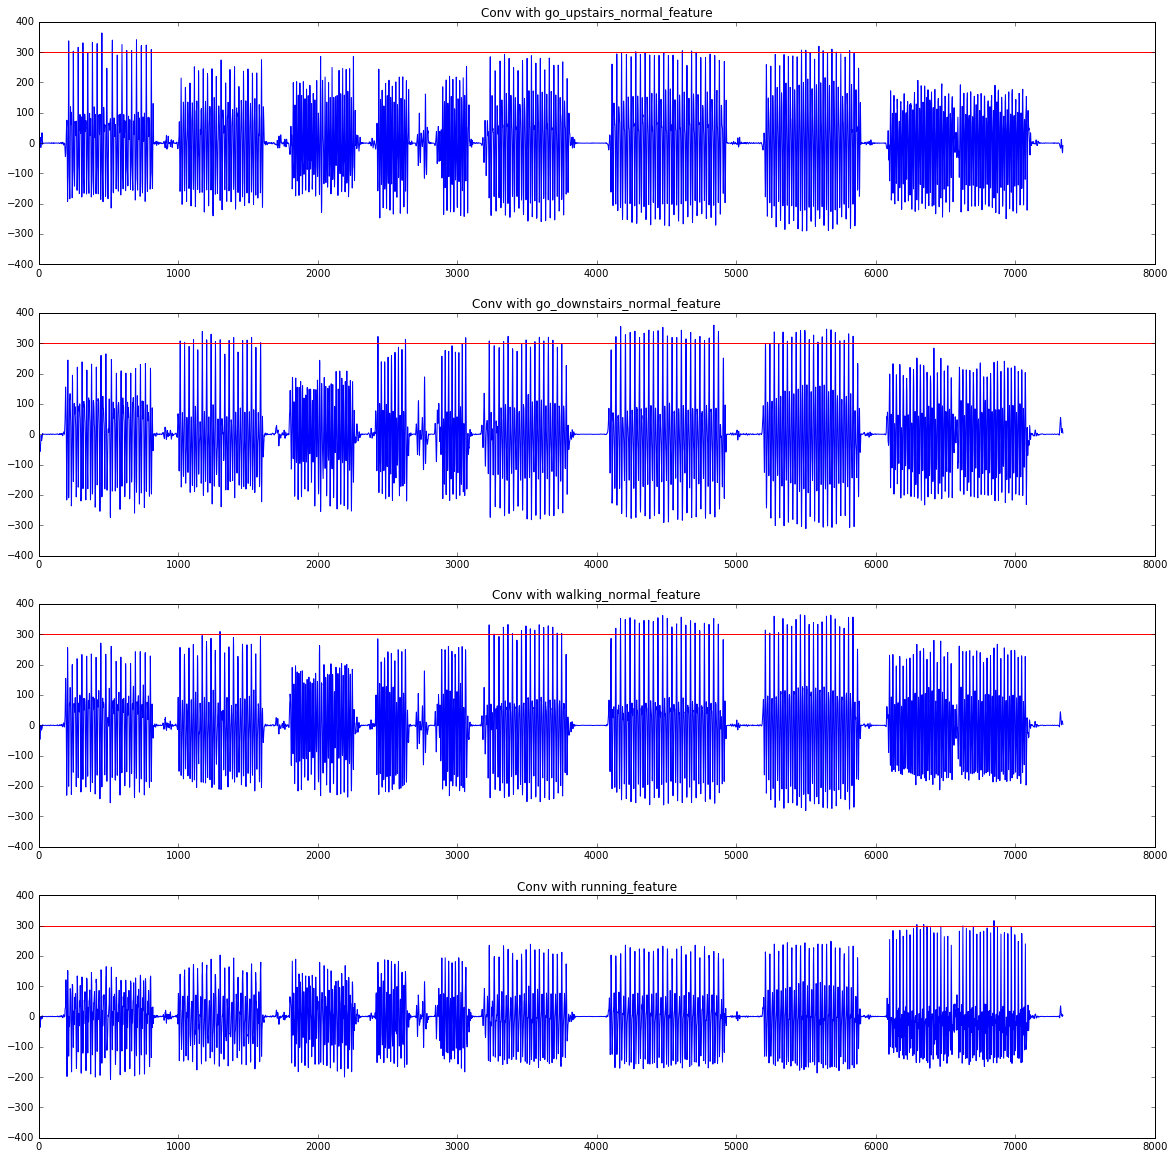

In [350]:
ax = xu.Plot_data(xu.m, "Magnitude","Xu's ACC Magitude")
ax.plot([28, 28], [-100, 150], 'r-',lw=2)
ax.text(5, 125, 'Go Upstairs (Normal)')

ax.plot([53, 53], [-100, 150], 'r-',lw=2)
ax.text(29, 125, 'Go Downstairs (Normal)')

ax.plot([72, 72], [-100, 150], 'r-',lw=2)
ax.text(55, 125, 'Run Upstairs')

ax.plot([98, 98], [-100, 150], 'r-',lw=2)
ax.text(75, 125, 'Run Downstairs')

ax.plot([125, 125], [-100, 150], 'r-',lw=2)
ax.text(100, 125, 'Walking (Noise)')

ax.plot([160, 160], [-100, 150], 'r-',lw=2)
ax.text(130, 125, 'Walking (Normal)')

ax.plot([188, 188], [-100, 150], 'r-',lw=2)
ax.text(165, 125, 'Walking Fast')
ax.text(200, 125, 'Running')

fig, ax = plt.subplots(4,1,figsize = (20,20))
conv1 = np.convolve(xu.m,go_upstairs_normal_feature2)
ax[0].plot(xrange(len(conv1)),conv1)
ax[0].set_ylim(-400,400)
ax[0].axhline(y=300,c="r",linewidth=1)
ax[0].set_title("Conv with go_upstairs_normal_feature")

conv2 = np.convolve(xu.m,go_downstairs_normal_feature2)
ax[1].plot(xrange(len(conv2)),conv2)
ax[1].set_ylim(-400,400)
ax[1].axhline(y=300,c="r",linewidth=1)
ax[1].set_title("Conv with go_downstairs_normal_feature")

conv3 = np.convolve(xu.m,walking_normal_feature2)
ax[2].plot(xrange(len(conv3)),conv3)
ax[2].set_ylim(-400,400)
ax[2].axhline(y=300,c="r",linewidth=1)
ax[2].set_title("Conv with walking_normal_feature")

conv4 = np.convolve(xu.m,running_feature2)
ax[3].plot(xrange(len(conv4)),conv4)
ax[3].set_ylim(-400,400)
ax[3].axhline(y=300,c="r",linewidth=1)
ax[3].set_title("Conv with running_feature")

Comparing the four convulusion results, we can see it gives higher magnitude when the signal is convoluted with the matched feature than convoluted with the rest three features. Thus, we may classify different features with this idea.

> ### Try to extract common features

I have extract my features of normal walking, running, going upstairs and going downstairs. They have shown different patterns. But, will the features be consistent among different people? Now see data from one of my friend, Renjing.

### Renjing

In [353]:
#Read CSV file and have a look at the acceleration data
df2 = pd.read_csv("Renjing/ACC_clean.csv", delimiter=",")
df2.head()

1479998284.000000   1479998284.000000   1479998284.000000.1
320               -9.0               -64.0                  -1.0
321              -12.0               -65.0                   1.0
322              -12.0               -65.0                   1.0
323              -12.0               -64.0                   0.0
324              -11.0               -64.0                  -1.0

Total Samples:  5765


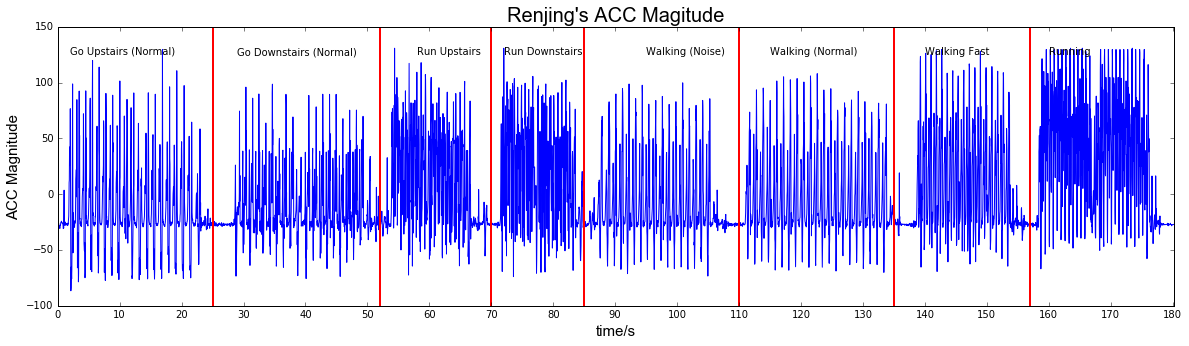

In [354]:
renjing = Processing(df2)
ax = renjing.Plot_data(renjing.m,"Magnitude", "Renjing's ACC Magitude")

ax.plot([25, 25], [-100, 150], 'r-',lw=2)
ax.text(2, 125, 'Go Upstairs (Normal)')

ax.plot([52, 52], [-100, 150], 'r-',lw=2)
ax.text(29, 125, 'Go Downstairs (Normal)')

ax.plot([70, 70], [-100, 150], 'r-',lw=2)
ax.text(58, 125, 'Run Upstairs')

ax.plot([85, 85], [-100, 150], 'r-',lw=2)
ax.text(72, 125, 'Run Downstairs')

ax.plot([110, 110], [-100, 150], 'r-',lw=2)
ax.text(95, 125, 'Walking (Noise)')

ax.plot([135, 135], [-100, 150], 'r-',lw=2)
ax.text(115, 125, 'Walking (Normal)')

ax.plot([157, 157], [-100, 150], 'r-',lw=2)
ax.text(140, 125, 'Walking Fast')
ax.text(160, 125, 'Running')

- Renjing's Going Upstairs (Normal)

Total Samples:  800
(29, 21)


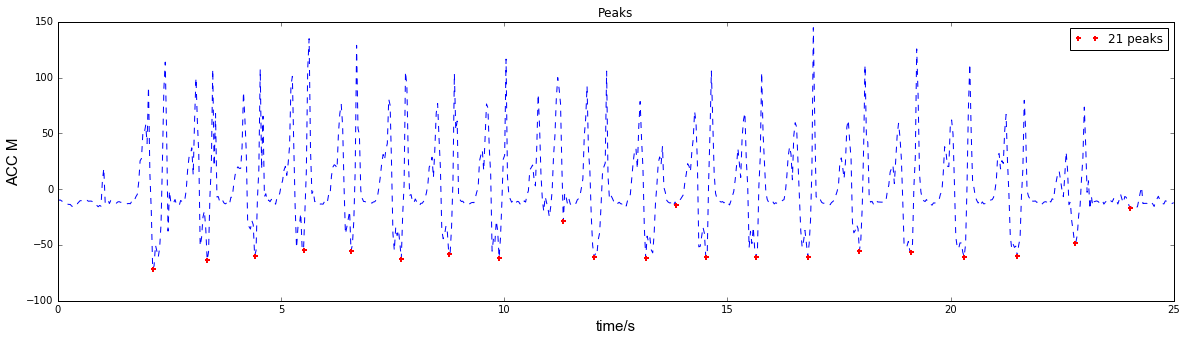

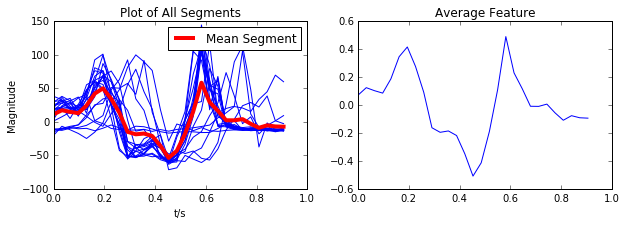

In [356]:
rj_go_upstairs_normal = Processing(renjing.Clip([0, 25]))
#rj_go_upstairs_normal.Plot_data(rj_go_upstairs_normal.m,"M", "Going Upstairs (Normal)")
rj_peaks = rj_go_upstairs_normal.Peaks(rj_go_upstairs_normal.m,"M", 0.3, 20 )
#rj_go_upstairs_normal.Plot_data(rj_go_upstairs_normal.m,"Magnitude", "Going Upstairs (Normal)",with_peaks=True, peaks = rj_peaks)
rj_go_upstairs_normal_feature1,rj_go_upstairs_normal_feature2,rj_go_upstairs_normal_set = rj_go_upstairs_normal.Segment_Feature(rj_go_upstairs_normal.m,14,rj_peaks)

- Renjing's Going Downstairs (Normal)

Total Samples:  704
(29, 20)


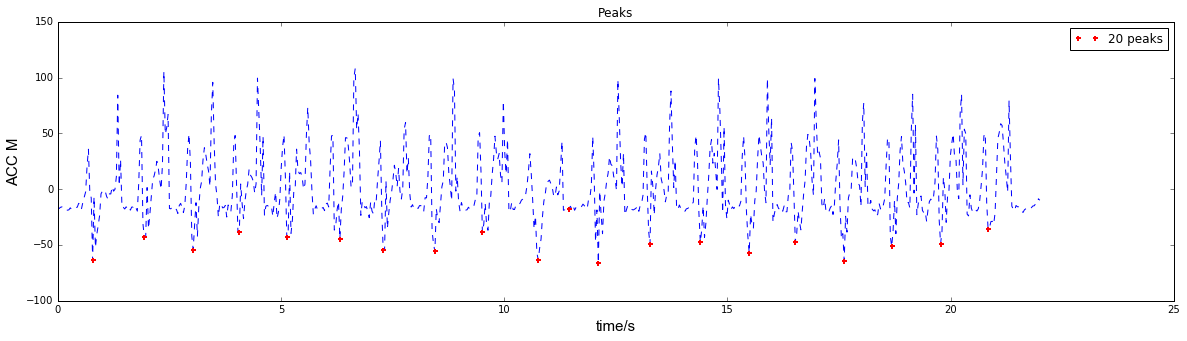

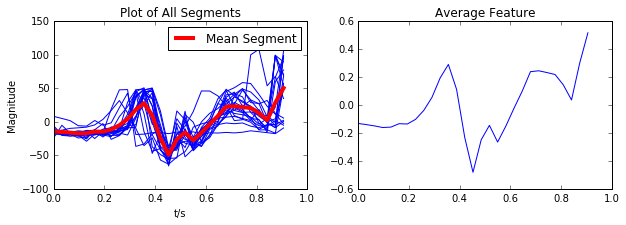

In [357]:
rj_go_downstairs_normal = Processing(renjing.Clip([28, 50]))
#rj_go_downstairs_normal.Plot_data(rj_go_downstairs_normal.m,"Magnitude","Going Downstairs (Normal)")
rj_peaks = rj_go_downstairs_normal.Peaks(rj_go_downstairs_normal.m,"M", 0.3, 20 )
#rj_go_downstairs_normal.Plot_data(rj_go_downstairs_normal.m,"Magnitude","Going Downstairs (Normal)",with_peaks=True, peaks = rj_peaks)
rj_go_downstairs_normal_feature1,rj_go_downstairs_normal_feature2,rj_go_downstairs_normal_set = rj_go_downstairs_normal.Segment_Feature(rj_go_downstairs_normal.m,14,rj_peaks)

- Renjing's Walking (Normal)

Total Samples:  800
(29, 22)


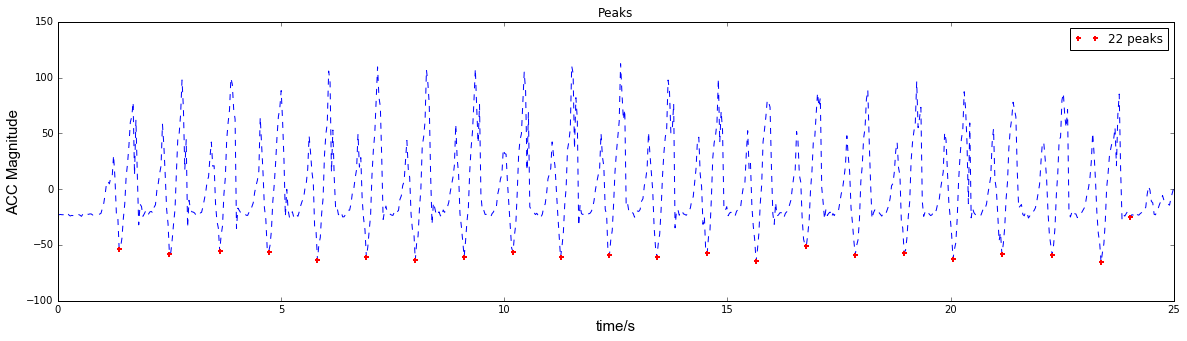

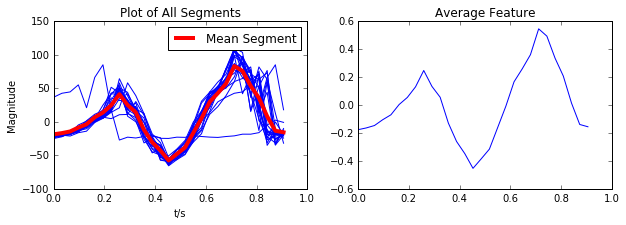

In [361]:
rj_walking_normal = Processing(renjing.Clip([110, 135]))
#rj_walking_normal.Plot_data(rj_walking_normal.m,"Magnitude","Walking (Normal)")
rj_peaks = rj_walking_normal.Peaks(rj_walking_normal.m,"Magnitude", 0.3, 20 )
#rj_walking_normal.Plot_data(rj_walking_normal.m,"Magnitude","Walking (Normal)",with_peaks=True, peaks = rj_peaks)
rj_walking_normal_feature1,rj_walking_normal_feature2,rj_walking_normal_set  = rj_walking_normal.Segment_Feature(rj_walking_normal.m,14,rj_peaks)

- Renjing's Running

Total Samples:  576
(29, 17)


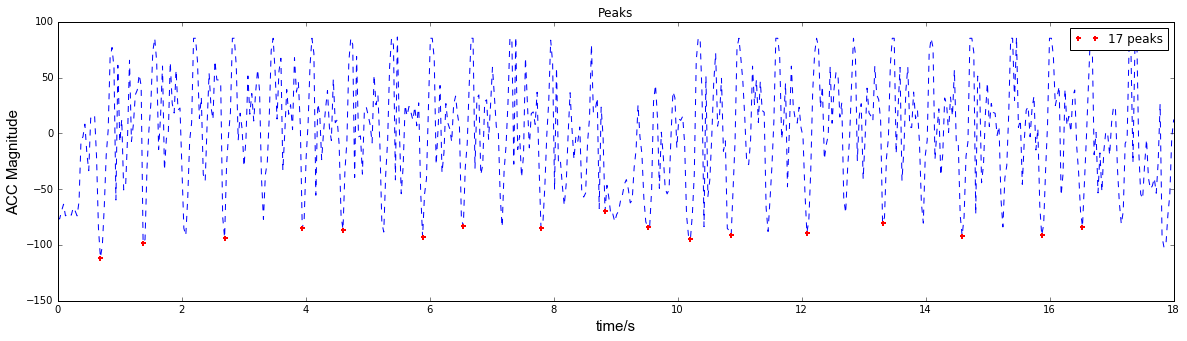

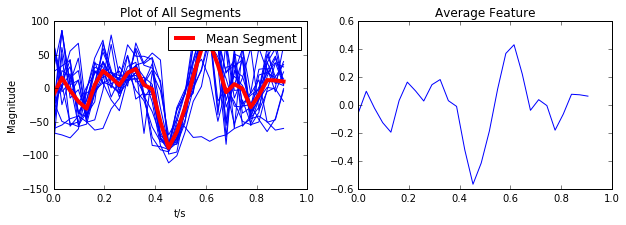

In [363]:
rj_running = Processing(renjing.Clip([158, 176]))
#rj_running.Plot_data(rj_running.m,"Magnitude","Running")
rj_peaks = rj_running.Peaks(rj_running.m, "Magnitude",0.3, 20 )
#rj_running.Plot_data(rj_running.m,"Magnitude","Running",with_peaks=True, peaks = rj_peaks)
rj_running_feature1,rj_running_feature2,rj_running_set = rj_running.Segment_Feature(rj_running.m,14,rj_peaks)

- Renjing's all features

Total Samples:  800
Total Samples:  704
Total Samples:  800
Total Samples:  576
(29, 21)
(29, 20)
(29, 22)
(29, 17)


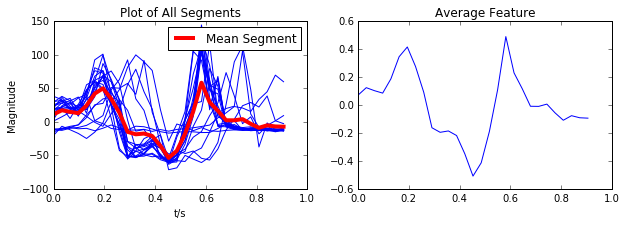

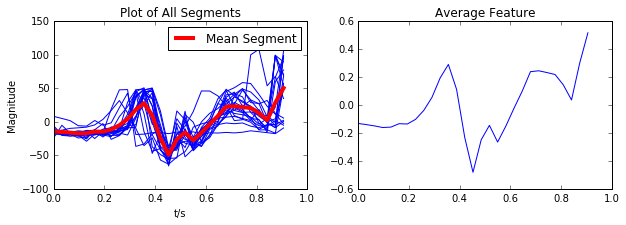

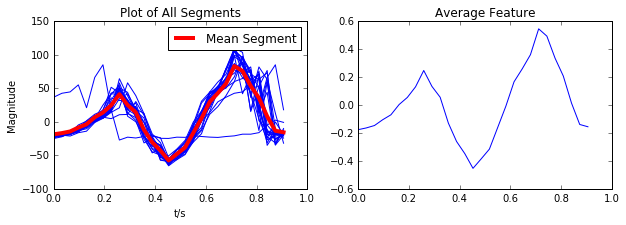

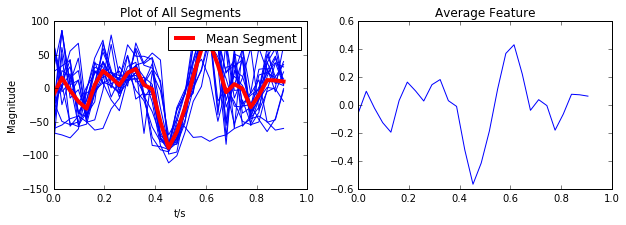

In [365]:
rj_features1, rj_features2, rj_features_set = renjing.extract_features(
    Processing(renjing.Clip([0, 25])),
    Processing(renjing.Clip([28, 50])),
    Processing(renjing.Clip([110, 135])),
    Processing(renjing.Clip([158, 176]))
)

- Matched Filter

I also test matched filter on his to validate the feasibility.

Total Samples:  5765


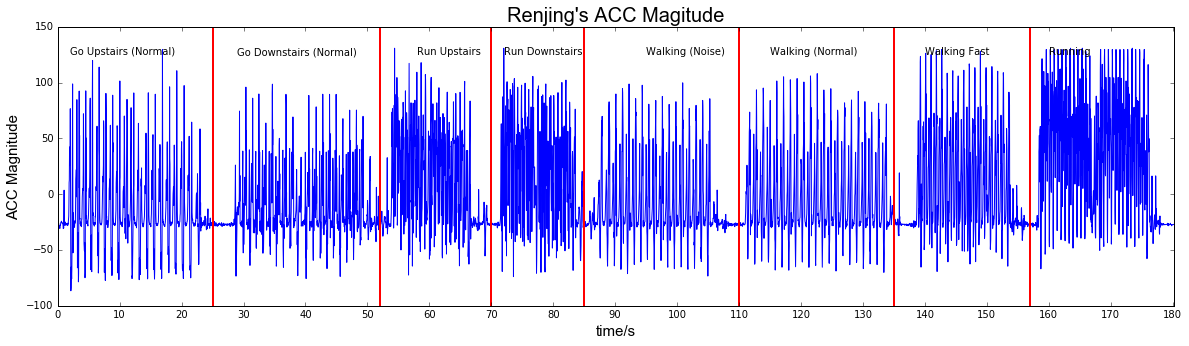

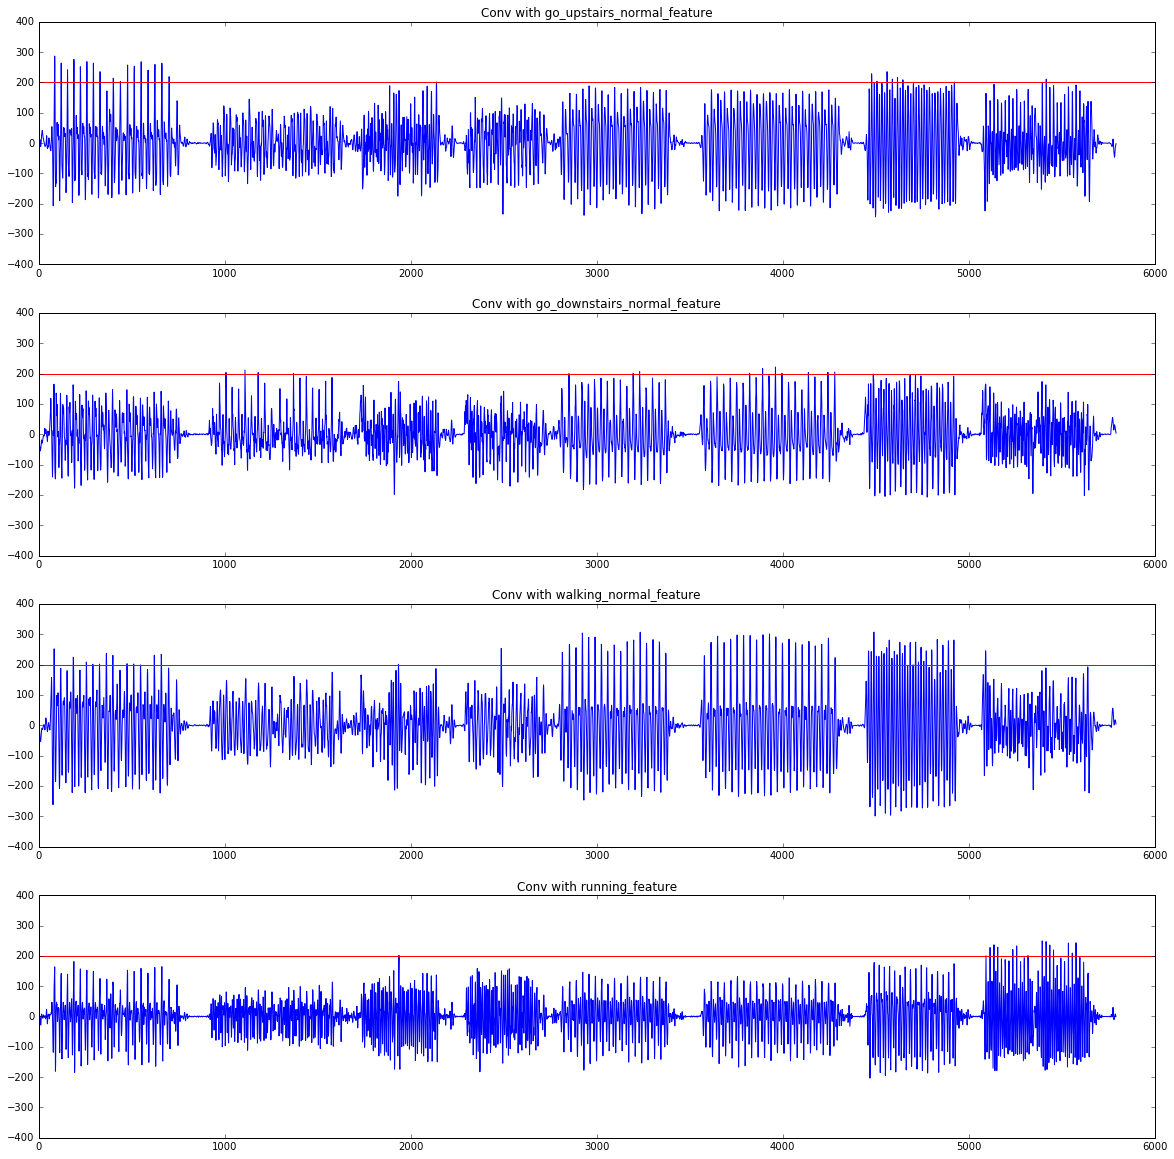

In [366]:
renjing = Processing(df2)
ax = renjing.Plot_data(renjing.m,"Magnitude", "Renjing's ACC Magitude")

ax.plot([25, 25], [-100, 150], 'r-',lw=2)
ax.text(2, 125, 'Go Upstairs (Normal)')

ax.plot([52, 52], [-100, 150], 'r-',lw=2)
ax.text(29, 125, 'Go Downstairs (Normal)')

ax.plot([70, 70], [-100, 150], 'r-',lw=2)
ax.text(58, 125, 'Run Upstairs')

ax.plot([85, 85], [-100, 150], 'r-',lw=2)
ax.text(72, 125, 'Run Downstairs')

ax.plot([110, 110], [-100, 150], 'r-',lw=2)
ax.text(95, 125, 'Walking (Noise)')

ax.plot([135, 135], [-100, 150], 'r-',lw=2)
ax.text(115, 125, 'Walking (Normal)')

ax.plot([157, 157], [-100, 150], 'r-',lw=2)
ax.text(140, 125, 'Walking Fast')
ax.text(160, 125, 'Running')

fig, ax = plt.subplots(4,1,figsize = (20,20))
conv1 = np.convolve(renjing.m,rj_go_upstairs_normal_feature2)
ax[0].plot(xrange(len(conv1)),conv1)
ax[0].set_ylim(-400,400)
ax[0].axhline(y=200,c="r",linewidth=1)
ax[0].set_title("Conv with go_upstairs_normal_feature")

conv2 = np.convolve(renjing.m,rj_go_downstairs_normal_feature2)
ax[1].plot(xrange(len(conv2)),conv2)
ax[1].set_ylim(-400,400)
ax[1].axhline(y=200,c="r",linewidth=1)
ax[1].set_title("Conv with go_downstairs_normal_feature")

conv3 = np.convolve(renjing.m,rj_walking_normal_feature2)
ax[2].plot(xrange(len(conv3)),conv3)
ax[2].set_ylim(-400,400)
ax[2].axhline(y=200,c="r",linewidth=1)
ax[2].set_title("Conv with walking_normal_feature")

conv4 = np.convolve(renjing.m,rj_running_feature2)
ax[3].plot(xrange(len(conv4)),conv4)
ax[3].set_ylim(-400,400)
ax[3].axhline(y=200,c="r",linewidth=1)
ax[3].set_title("Conv with running_feature")

Again!! Really nice result! Matched filter gives good accuracy in classifying different moving behaviors.

### Extract Common Features

So far, we have seen the good results using matched filter individually. But it is not enough, we shall try to convolute the whole signal with common features (average feature of several people) and prove that there is similarity, for example, of walking among different people. Then we can do matched filter with the common feature to detect moving behaviors of a random person.

I will keep collect data from another 4 friends of mine.

### Ai

In [367]:
#Read CSV file and have a look at the acceleration data
Ai = pd.read_csv("Ai/ACC.csv", delimiter=",")
Ai.head()

1479956522.000000   1479956522.000000   1479956522.000000.1
0               32.0                32.0                  32.0
1              -10.0               -63.0                  -7.0
2              -10.0               -63.0                  -7.0
3              -10.0               -62.0                  -7.0
4              -10.0               -63.0                  -7.0

Total Samples:  6649


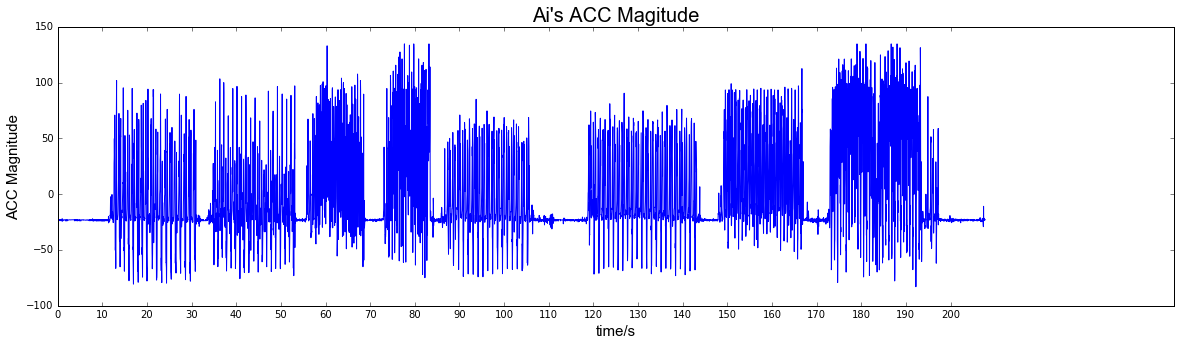

In [368]:
#--------------------------
#Plot the ACC magnitude data by time
#--------------------------

#read in the whole data
ai = Processing(Ai)
ax = ai.Plot_data(ai.m,"Magnitude", "Ai's ACC Magitude")

- Ai's all features

Total Samples:  575
Total Samples:  736
Total Samples:  960
Total Samples:  736
(29, 16)
(29, 22)
(29, 28)
(29, 27)


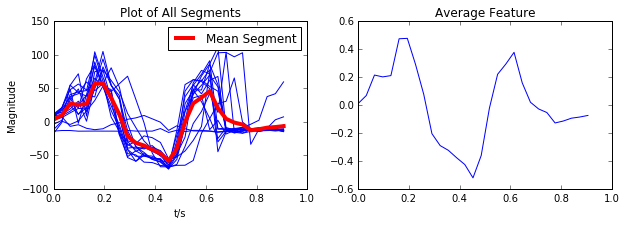

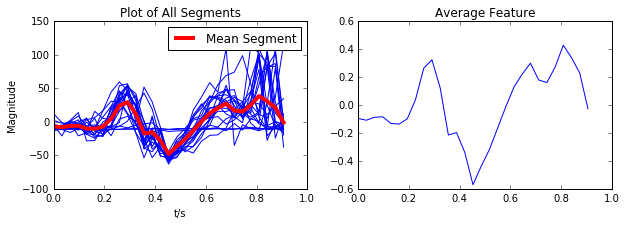

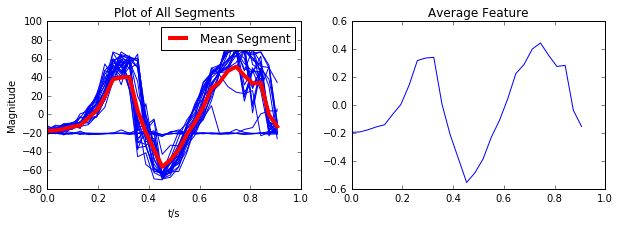

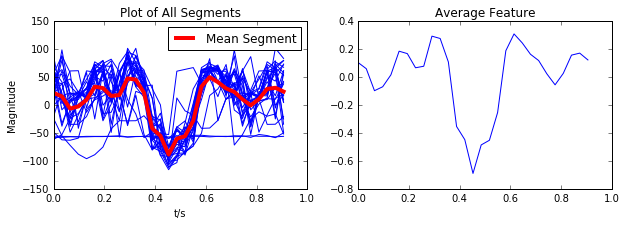

In [369]:
ai_features1,ai_features2, ai_features_set = ai.extract_features(
    Processing(ai.Clip([10, 28])),
    Processing(ai.Clip([32, 55])),
    Processing(ai.Clip([115, 145])),
    Processing(ai.Clip([170, 193]))
)

### Ran 

In [370]:
#Read CSV file and have a look at the acceleration data
Ran = pd.read_csv("Ran/ACC.csv", delimiter=",")
Ran.head()

1479956890.000000   1479956890.000000   1479956890.000000.1
0               32.0                32.0                  32.0
1               -9.0               -63.0                   0.0
2               -9.0               -63.0                   0.0
3              -10.0               -63.0                   2.0
4              -11.0               -63.0                   3.0

Total Samples:  7231


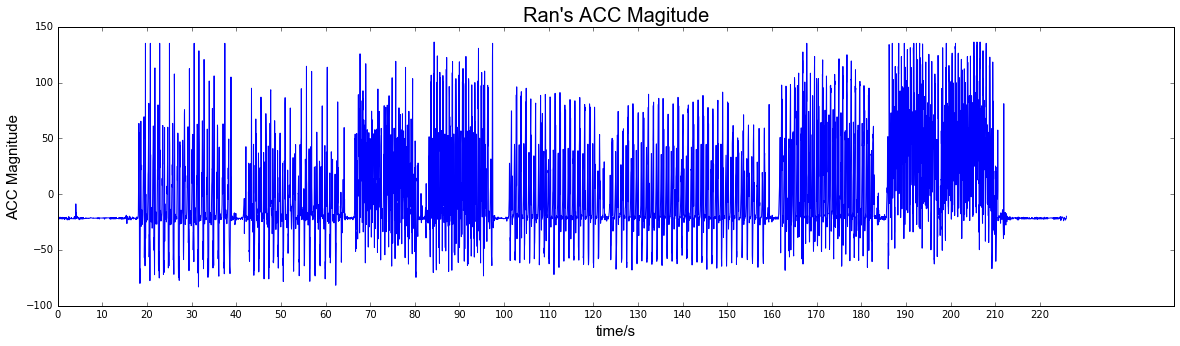

In [371]:
#--------------------------
#Plot the ACC magnitude data by time
#--------------------------

#read in the whole data
ran = Processing(Ran)
ax = ran.Plot_data(ran.m,"Magnitude", "Ran's ACC Magitude")

Total Samples:  768
Total Samples:  768
Total Samples:  1153
Total Samples:  800
(29, 20)
(29, 20)
(29, 30)
(29, 29)


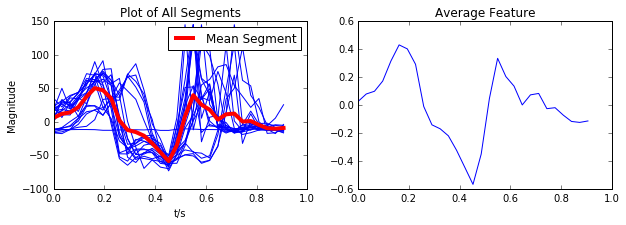

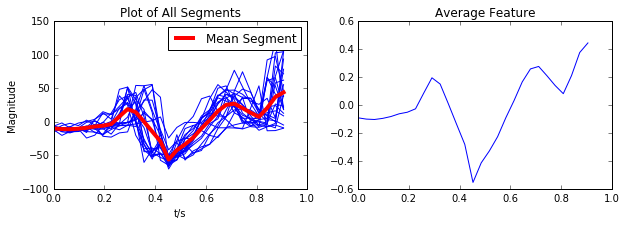

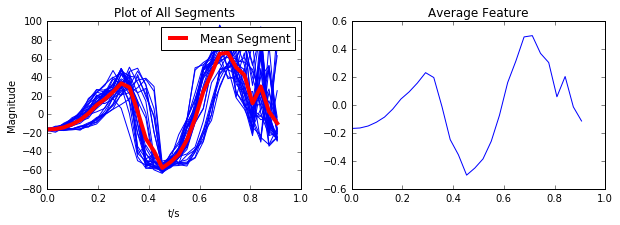

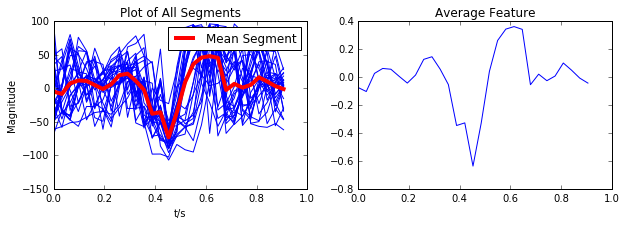

In [372]:
ran_features1,ran_features2, ran_features_set = ran.extract_features(
    Processing(ran.Clip([16, 40])),
    Processing(ran.Clip([41, 65])),
    Processing(ran.Clip([124, 160])),
    Processing(ran.Clip([185, 210]))
)

### Yan

In [373]:
#Read CSV file and have a look at the acceleration data
Yan = pd.read_csv("Yan/ACC.csv", delimiter=",")
Yan.head()

1479957298.000000   1479957298.000000   1479957298.000000.1
0               32.0                32.0                  32.0
1                8.0                63.0                 -11.0
2                8.0                63.0                 -11.0
3                8.0                63.0                 -11.0
4                7.0                63.0                 -11.0

Total Samples:  6733


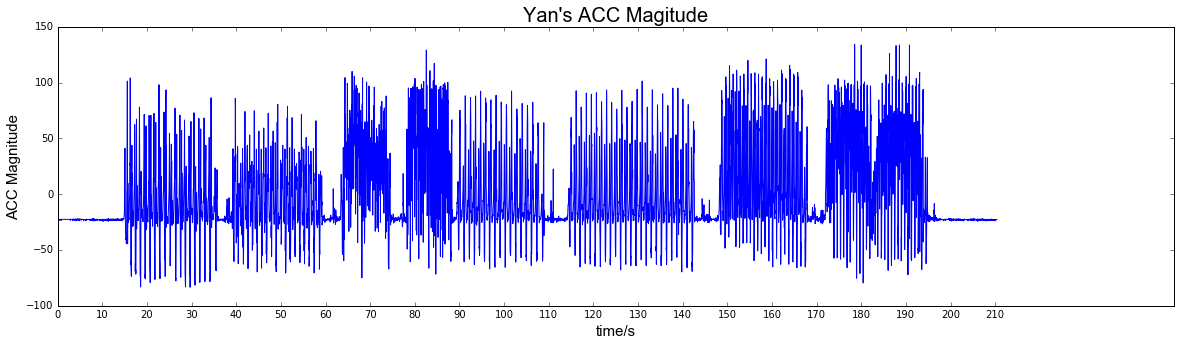

In [374]:
#--------------------------
#Plot the ACC magnitude data by time
#--------------------------

#read in the whole data
yan = Processing(Yan)
ax = yan.Plot_data(yan.m,"Magnitude", "Yan's ACC Magitude")

Total Samples:  704
Total Samples:  736
Total Samples:  896
Total Samples:  800
(29, 19)
(29, 20)
(29, 24)
(29, 30)


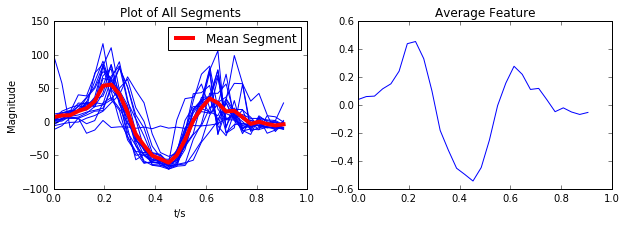

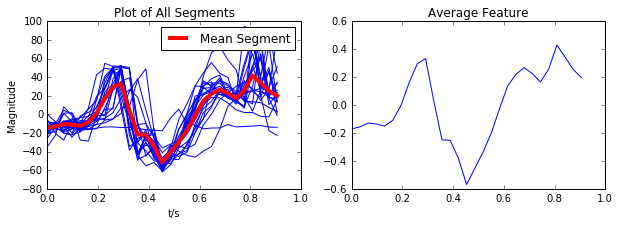

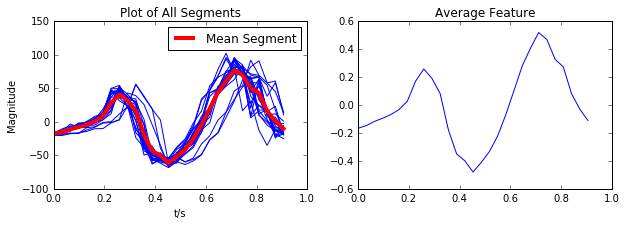

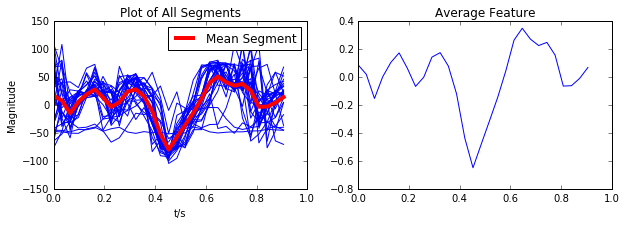

In [375]:
yan_features1,yan_features2, yan_features_set = yan.extract_features(
    Processing(yan.Clip([15, 37])),
    Processing(yan.Clip([37, 60])),
    Processing(yan.Clip([115, 143])),
    Processing(yan.Clip([170, 195]))
)

### Tang

In [376]:
#Read CSV file and have a look at the acceleration data
Tang = pd.read_csv("Tang/ACC.csv", delimiter=",")
Tang.head()

1479997406.000000   1479997406.000000   1479997406.000000.1
0               32.0                32.0                  32.0
1               -3.0               -63.0                   5.0
2               -2.0               -63.0                   5.0
3               -3.0               -63.0                   5.0
4               -3.0               -63.0                   5.0

Total Samples:  7315


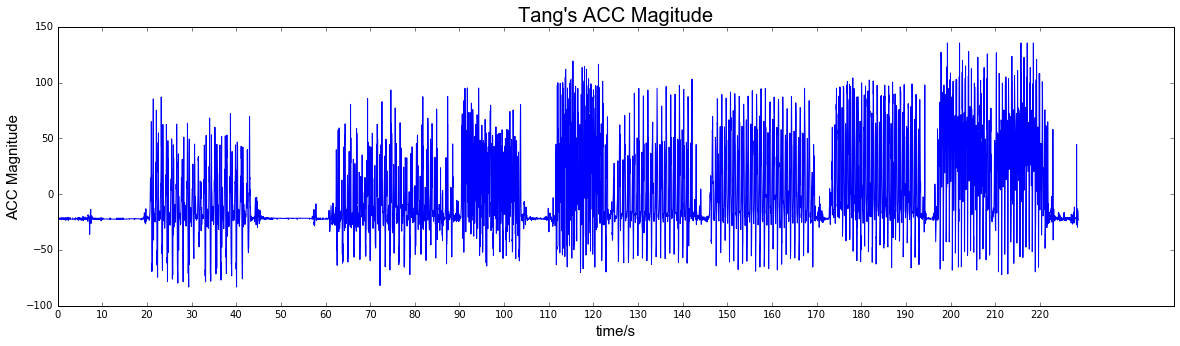

In [377]:
#--------------------------
#Plot the ACC magnitude data by time
#--------------------------

#read in the whole data
tang = Processing(Tang)
ax = tang.Plot_data(tang.m,"Magnitude", "Tang's ACC Magitude")

Total Samples:  736
Total Samples:  960
Total Samples:  800
Total Samples:  864
(29, 19)
(29, 27)
(29, 24)
(29, 37)


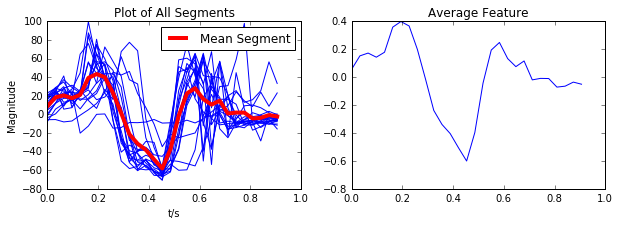

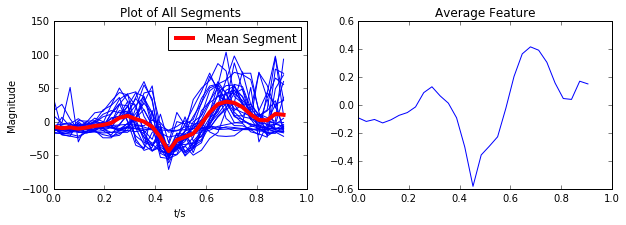

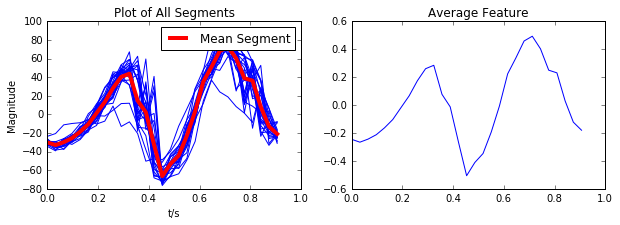

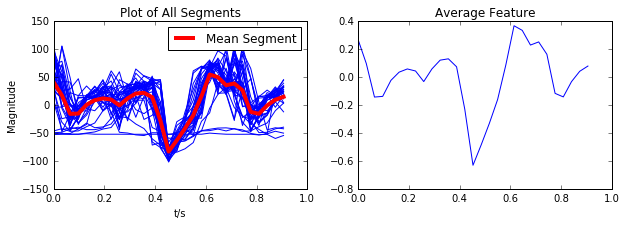

In [378]:
tang_features1,tang_features2, tang_features_set = tang.extract_features(
    Processing(tang.Clip([20, 43])),
    Processing(tang.Clip([60, 90])),
    Processing(tang.Clip([145, 170])),
    Processing(tang.Clip([195, 222]))
)

> ## Do matched filter with average features

Now, I have the four average features of the six of us. Let us get the common features and test matched filter. 

### Get average features

In [381]:
#average features different people
people = [ran_features1,yan_features1,xu_features1,rj_features1,tang_features1,ai_features1]

up_sum = np.zeros(29)
down_sum = np.zeros(29)
walk_sum = np.zeros(29)
run_sum = np.zeros(29)

n = len(people)
for i in range(n):
    up_sum += people[i][0]
    down_sum += people[i][1]
    walk_sum += people[i][2]
    run_sum += people[i][3]
        
up = up_sum / n - (up_sum / n).mean()
down = down_sum / n - (down_sum / n).mean()
walk = walk_sum / n - (walk_sum / n).mean()
run = run_sum / n - (run_sum / n).mean()

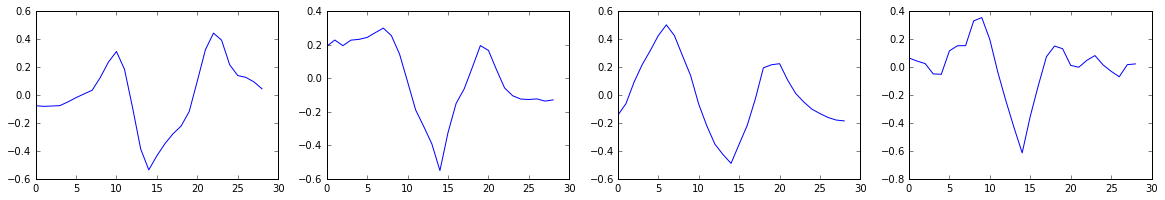

In [382]:
fig, ax = plt.subplots(1,4,figsize = (20,3))
ax[0].plot(range(len(up)),up)
ax[1].plot(range(len(down)),down)
ax[2].plot(range(len(walk)),walk)
ax[3].plot(range(len(run)),run)

### Matched Filter

Having the common filter, I apply matched filter with Renjing's and my signal again to see the results.

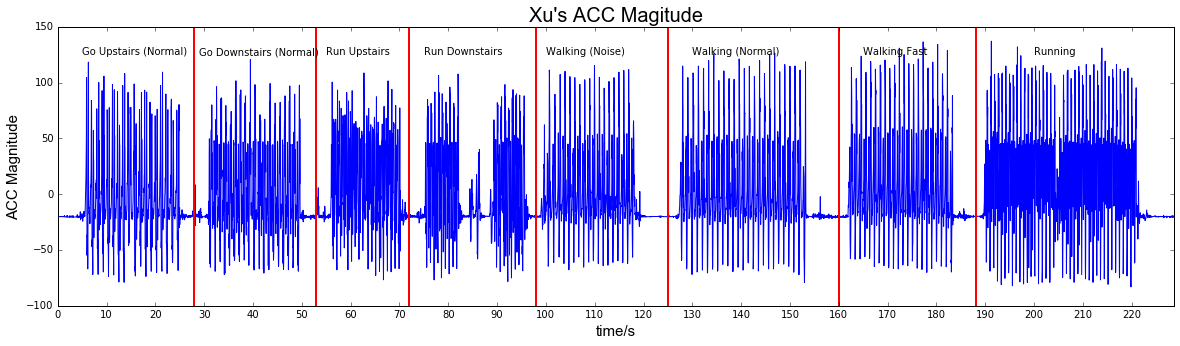

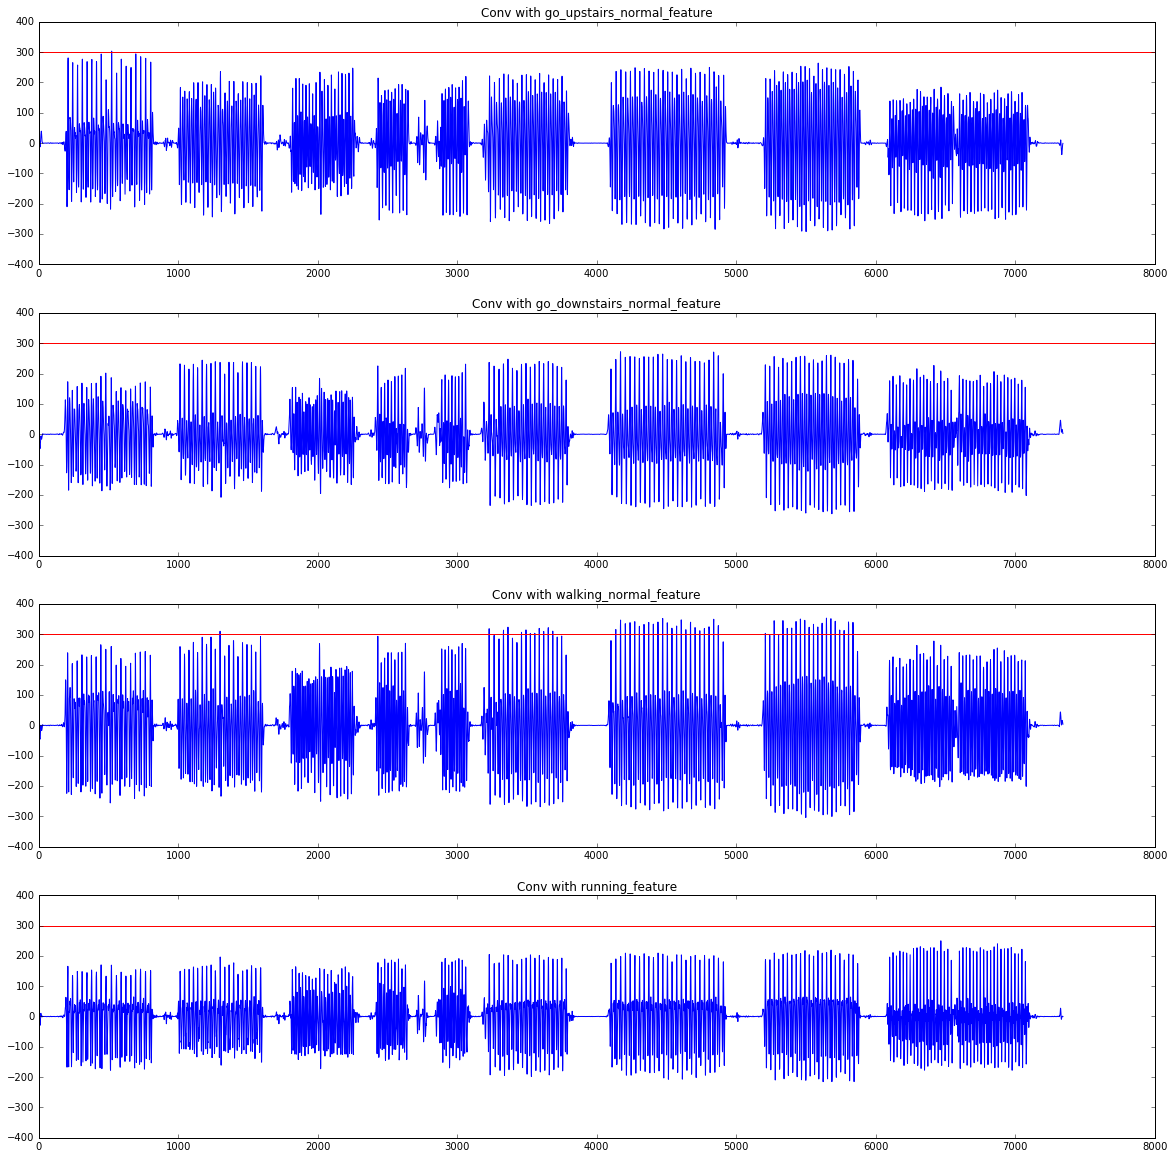

In [383]:
ax = xu.Plot_data(xu.m, "Magnitude","Xu's ACC Magitude")
ax.plot([28, 28], [-100, 150], 'r-',lw=2)
ax.text(5, 125, 'Go Upstairs (Normal)')

ax.plot([53, 53], [-100, 150], 'r-',lw=2)
ax.text(29, 125, 'Go Downstairs (Normal)')

ax.plot([72, 72], [-100, 150], 'r-',lw=2)
ax.text(55, 125, 'Run Upstairs')

ax.plot([98, 98], [-100, 150], 'r-',lw=2)
ax.text(75, 125, 'Run Downstairs')

ax.plot([125, 125], [-100, 150], 'r-',lw=2)
ax.text(100, 125, 'Walking (Noise)')

ax.plot([160, 160], [-100, 150], 'r-',lw=2)
ax.text(130, 125, 'Walking (Normal)')

ax.plot([188, 188], [-100, 150], 'r-',lw=2)
ax.text(165, 125, 'Walking Fast')
ax.text(200, 125, 'Running')

fig, ax = plt.subplots(4,1,figsize = (20,20))
conv1 = np.convolve(xu.m,up)
ax[0].plot(xrange(len(conv1)),conv1)
ax[0].set_ylim(-400,400)
ax[0].axhline(y=300,c="r",linewidth=1)
ax[0].set_title("Conv with go_upstairs_normal_feature")

conv2 = np.convolve(xu.m,down)
ax[1].plot(xrange(len(conv2)),conv2)
ax[1].set_ylim(-400,400)
ax[1].axhline(y=300,c="r",linewidth=1)
ax[1].set_title("Conv with go_downstairs_normal_feature")

conv3 = np.convolve(xu.m,walk)
ax[2].plot(xrange(len(conv3)),conv3)
ax[2].set_ylim(-400,400)
ax[2].axhline(y=300,c="r",linewidth=1)
ax[2].set_title("Conv with walking_normal_feature")

conv4 = np.convolve(xu.m,run)
ax[3].plot(xrange(len(conv4)),conv4)
ax[3].set_ylim(-400,400)
ax[3].axhline(y=300,c="r",linewidth=1)
ax[3].set_title("Conv with running_feature")

Total Samples:  5765


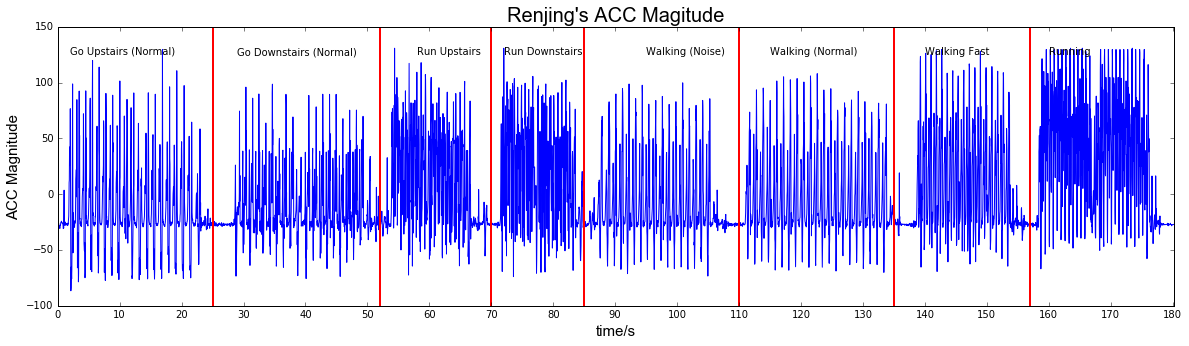

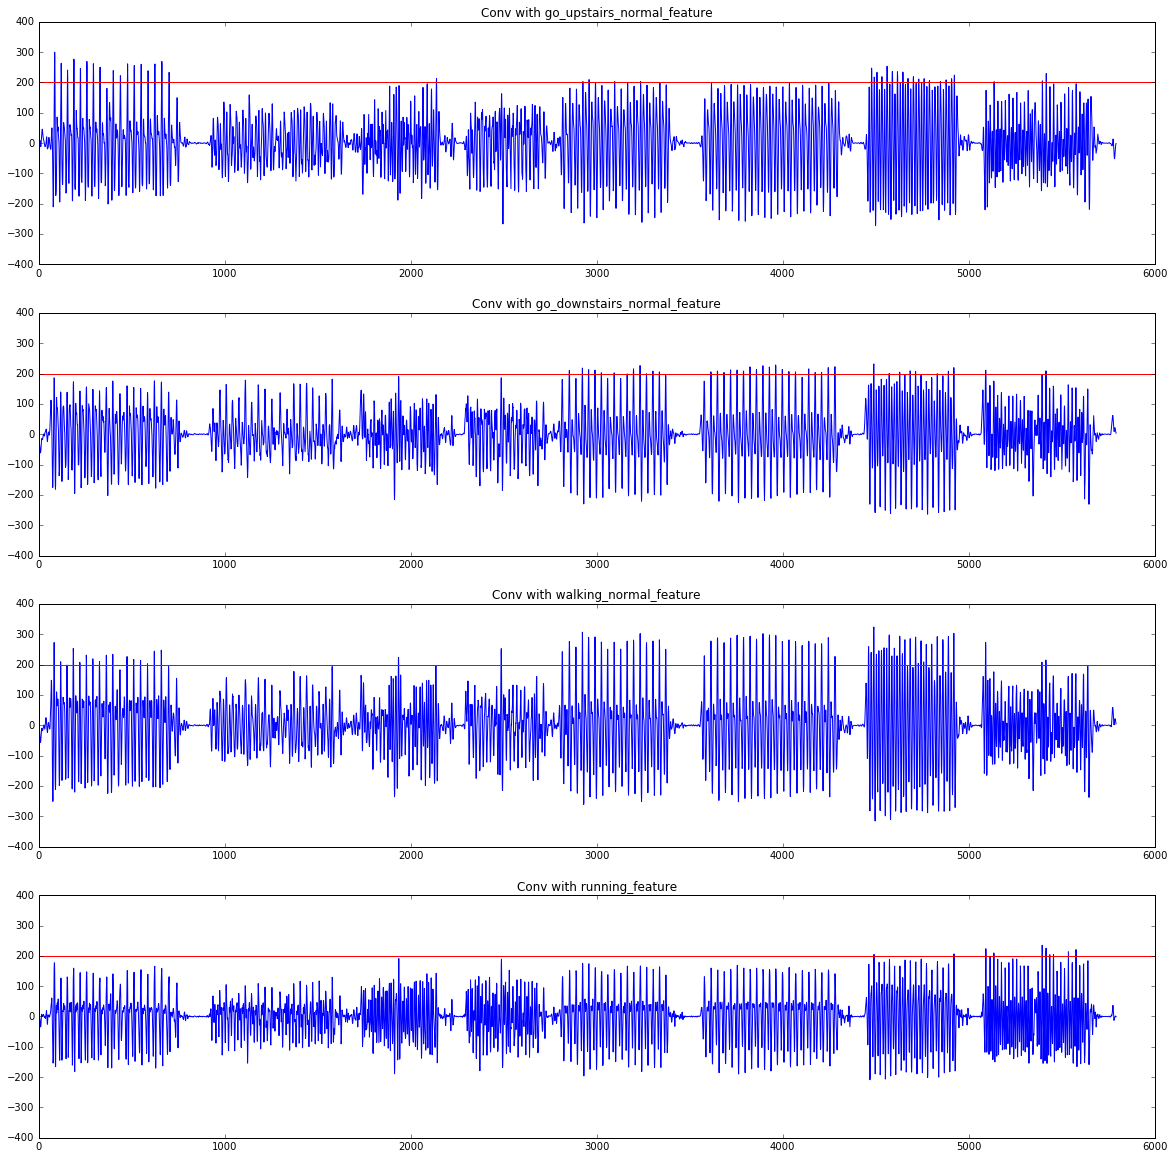

In [384]:
renjing = Processing(df2)
ax = renjing.Plot_data(renjing.m,"Magnitude", "Renjing's ACC Magitude")

ax.plot([25, 25], [-100, 150], 'r-',lw=2)
ax.text(2, 125, 'Go Upstairs (Normal)')

ax.plot([52, 52], [-100, 150], 'r-',lw=2)
ax.text(29, 125, 'Go Downstairs (Normal)')

ax.plot([70, 70], [-100, 150], 'r-',lw=2)
ax.text(58, 125, 'Run Upstairs')

ax.plot([85, 85], [-100, 150], 'r-',lw=2)
ax.text(72, 125, 'Run Downstairs')

ax.plot([110, 110], [-100, 150], 'r-',lw=2)
ax.text(95, 125, 'Walking (Noise)')

ax.plot([135, 135], [-100, 150], 'r-',lw=2)
ax.text(115, 125, 'Walking (Normal)')

ax.plot([157, 157], [-100, 150], 'r-',lw=2)
ax.text(140, 125, 'Walking Fast')
ax.text(160, 125, 'Running')

fig, ax = plt.subplots(4,1,figsize = (20,20))
conv1 = np.convolve(renjing.m,up)
ax[0].plot(xrange(len(conv1)),conv1)
ax[0].set_ylim(-400,400)
ax[0].axhline(y=200,c="r",linewidth=1)
ax[0].set_title("Conv with go_upstairs_normal_feature")

conv2 = np.convolve(renjing.m,down)
ax[1].plot(xrange(len(conv2)),conv2)
ax[1].set_ylim(-400,400)
ax[1].axhline(y=200,c="r",linewidth=1)
ax[1].set_title("Conv with go_downstairs_normal_feature")

conv3 = np.convolve(renjing.m,walk)
ax[2].plot(xrange(len(conv3)),conv3)
ax[2].set_ylim(-400,400)
ax[2].axhline(y=200,c="r",linewidth=1)
ax[2].set_title("Conv with walking_normal_feature")

conv4 = np.convolve(renjing.m,run)
ax[3].plot(xrange(len(conv4)),conv4)
ax[3].set_ylim(-400,400)
ax[3].axhline(y=200,c="r",linewidth=1)
ax[3].set_title("Conv with running_feature")

Although they are not as obvious as before, we can tell the highest magtidues from the convulusion results. 

**Matched filter can be seen as part of the probabilistic LDA. From above, we test the idea of matched filter and having optimistic results, I will later implement probabilistic LDA to classify different moving behaviors.**

But, before that, let us visualize the difference using PCA. I choose to project the data onto the first 3 components to maintain as much variance as possible.

### PCA


In [545]:
def PCA(x,y,n):
    x = np.transpose(x)
    #remove mean
    N = x.shape[1] # len of data
    mean = np.mean(x, axis = 1)
    mu = np.repeat(mean.reshape(-1,1),N,axis = 1)
    x = x - mu
    #PCA matrix
    C = np.cov(x)
    D, V = np.linalg.eig(C)
    D = D.real
    V = V.real
    
    #projection
    p = np.transpose(V).dot(x)
    
    
    return p[:n,:]

def plot_PCA(x,y,n):
    
    x_reduced = np.transpose(PCA(x,y,n))
    up = go.Scatter3d(
            name = "up",
            x=x_reduced[y==1, 0],
            y=x_reduced[y==1, 1],
            z=x_reduced[y==1, 2],
            mode='markers',
            marker=dict(
                size=3,
                line=dict(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0
                ),
                opacity=0.8
            )
        )


    down = go.Scatter3d(
        name = "down",
        x=x_reduced[y==2, 0],
        y=x_reduced[y==2, 1],
        z=x_reduced[y==2, 2],
        mode='markers',
        marker=dict(
            color='rgb(127, 127, 127)',
            size=3,
            symbol='circle',
            line=dict(
                color='rgb(204, 204, 204)',
                width=0
            ),
            opacity=0.9
        )
    )
        
    walk = go.Scatter3d(
        name = "walk",
        x=x_reduced[y==3, 0],
        y=x_reduced[y==3, 1],
        z=x_reduced[y==3, 2],
        mode='markers',
        marker=dict(
            size=3,
            line=dict(
                color='rgb(228,26,28)',
                width=0
            ),
            opacity=0.8
        )
    )

    run = go.Scatter3d(
        name = "run",
        x=x_reduced[y==4, 0],
        y=x_reduced[y==4, 1],
        z=x_reduced[y==4, 2],
        mode='markers',
        marker=dict(
            size=3,
            line=dict(
                color='rgb(77,175,74)',
                width=0
            ),
            opacity=0.8
        )
    )
        
    dataset = [up,down,walk,run]

    layout = dict(
            width=800,
            height=550,
            autosize=False,
            title='PCA of Moving Behaviors Average Features',
            scene=dict(
                xaxis=dict(
                    gridcolor='rgb(255, 255, 255)',
                    zerolinecolor='rgb(255, 255, 255)',
                    showbackground=True,
                    backgroundcolor='rgb(230, 230,230)'
                ),
                yaxis=dict(
                    gridcolor='rgb(255, 255, 255)',
                    zerolinecolor='rgb(255, 255, 255)',
                    showbackground=True,
                    backgroundcolor='rgb(230, 230,230)'
                ),
                zaxis=dict(
                    gridcolor='rgb(255, 255, 255)',
                    zerolinecolor='rgb(255, 255, 255)',
                    showbackground=True,
                    backgroundcolor='rgb(230, 230,230)'
                ),
                aspectratio = dict( x=1, y=1, z=0.7 ),
                aspectmode = 'manual'        
            ),
        )

    fig = dict(data=dataset, layout=layout)
    py.plot(fig, filename='Moving Behavior')

In [696]:
people_set = [ran_features_set,yan_features_set,xu_features_set,rj_features_set,tang_features_set,ai_features_set]
feature = Features(people_set[0][0],people_set[0][1],people_set[0][2],people_set[0][3])

for i in range(1,len(people_set)):
    x_all,y = feature.learn(people_set[i][0],people_set[i][1],people_set[i][2],people_set[i][3])  

In [547]:
plot_PCA(x_all,y,3)

In [548]:
tls.embed("https://plot.ly/~Sophie301/2")

Of the first three components, we see 4 well-separate clusters. Both visually (PCA) and mathematically (matched filter), we see clear evidence that there indeed is difference of the four moving behaviors.

Now, we should expect that probablistic LDA approach will work well in distinguish the four classes!!

### Probabilistic LDA

In [519]:
def LDA(x,y):
    classes = np.unique(y) # classes
    var = np.cov(np.transpose(x)) #covariance matrix
    result = []
    
    
    for d in x:
        prob = [] #calculate the probability of 4 classes
        for c in classes:
            x_each = x[y==c] #get data from each class
            mu = np.mean(x_each,axis = 0)
            
            #approximated posterior probability 
            log = d.dot(np.linalg.inv(var)).dot(np.transpose(mu)) - 1/2. * mu.dot(np.linalg.inv(var)).dot(np.transpose(mu)) + np.log(len(y[y==c])/float(len(y))) 
            prob.append(log)
        
        #assign to class that argmax the prob
        result.append(np.argmax(prob) + 1)
    result = np.asarray(result)
     
    print "up stairs accuracy:", (y[y == 1] == result[y==1.]).sum() / float(len(y[y == 1]))  
    print "down stairs accuracy:", (y[y == 2] == result[y==2.]).sum() / float(len(y[y == 2]))
    print "walk accuracy:", (y[y == 3] == result[y==3.]).sum() / float(len(y[y == 3]))
    print "run accuracy:", (y[y == 4] == result[y==4.]).sum() / float(len(y[y == 4]))
    print "total accuracy: ",(y == result).sum() / float(len(y))  
    return y, result

In [520]:
y, result = LDA(x_all,y)

up stairs accuracy: 0.840707964602
down stairs accuracy: 0.858267716535
walk accuracy: 0.904109589041
run accuracy: 0.915254237288
total accuracy:  0.884547069272


| | Go Up Stairs   | Go Down Stairs | Walk |Run| **Total Accuracy**|
|------|------|
|**Class Accuracy**|0.84 |0.86|0.90|0.92|**0.88** |

Finally, I achieve a total accuracy of **0.88** on moving behavior classification using data from 6 people. 

> ## People Recognition

From the above, we see similarity among people in the four moving behaviors: going upstairs, going downstairs,walking and running and are able to achieve good accuracy on moving behavior classificatio. 

Next, I will apply LDA to recognize people using individual distinguishable features.

In [647]:
#Define a class to learn features
class Recognition:
    def __init__(self,up,down,walk,run):
        self.n = 1 #number of people
        
        self.up = up
        self.down = down
        self.walk = walk
        self.run = run
        
        self.y1 = np.empty(self.up.shape[0])
        self.y1.fill(self.n)
        
        self.y2 = np.empty(self.down.shape[0])
        self.y2.fill(self.n)
        
        self.y3 = np.empty(self.walk.shape[0])
        self.y3.fill(self.n)
        
        self.y4 = np.empty(self.run.shape[0])
        self.y4.fill(self.n)
        
        self.min_size = np.min([self.up.shape[0],self.down.shape[0],self.walk.shape[0],self.run.shape[0]])
        self.full = np.concatenate((self.up[:self.min_size,:],self.down[:self.min_size,:],self.walk[:self.min_size,:],self.run[:self.min_size,:]),axis = 1)
        self.y = np.empty(self.min_size)
        self.y.fill(self.n)
    
       
        return 
        
        
    def learn(self,up,down,walk,run):
        self.n +=1
        
        
        y1 = np.empty(up.shape[0])
        y1.fill(self.n)
        self.y1 = np.concatenate((self.y1,y1))
        
        y2 = np.empty(down.shape[0])
        y2.fill(self.n)
        self.y2 = np.concatenate((self.y2,y2))
        
        y3 = np.empty(walk.shape[0])
        y3.fill(self.n)
        self.y3 = np.concatenate((self.y3,y3))
        
        y4 = np.empty(run.shape[0])
        y4.fill(self.n)
        self.y4 = np.concatenate((self.y4,y4))
        
        self.up = np.concatenate((self.up,up))
        self.down = np.concatenate((self.down,down))
        self.walk = np.concatenate((self.walk,walk))
        self.run = np.concatenate((self.run,run))
        
        #concatenate all moving behaviors, using the minimum size
        #trim the features to have same size
        
        self.min_size = np.min([up.shape[0],down.shape[0],walk.shape[0],run.shape[0]])
        full = np.concatenate((up[:self.min_size,:],down[:self.min_size,:],walk[:self.min_size,:],run[:self.min_size,:]),axis = 1)
        y = np.empty(self.min_size)
        y.fill(self.n)
        self.full = np.concatenate((self.full,full))
        self.y = np.concatenate((self.y,y))
       
        #print len(self.y1),len(self.y2),len(self.y3),len(self.y4),len(self.y)
        
        x = [self.up,self.down,self.walk,self.run,self.full]
        y = [self.y1,self.y2,self.y3,self.y4,self.y]
        return x,y

In [640]:
def LDA2(x,y):
    classes = np.unique(y) # classes
    var = np.cov(np.transpose(x)) #covariance matrix
    result = []
    
    
    for d in x:
        prob = [] #calculate the probability of 4 classes
        for c in classes:
            x_each = x[y==c] #get data from each class
            mu = np.mean(x_each,axis = 0)
            
            #approximated posterior probability 
            log = d.dot(np.linalg.inv(var)).dot(np.transpose(mu)) - 1/2. * mu.dot(np.linalg.inv(var)).dot(np.transpose(mu)) + np.log(len(y[y==c])/float(len(y))) 
            prob.append(log)
        
        #assign to class that argmax the prob
        result.append(np.argmax(prob) + 1)
    result = np.asarray(result)
     
    print "person1 accuracy:", (y[y == 1] == result[y==1.]).sum() / float(len(y[y == 1]))  
    print "person2 accuracy:", (y[y == 2] == result[y==2.]).sum() / float(len(y[y == 2]))
    print "person3 accuracy:", (y[y == 3] == result[y==3.]).sum() / float(len(y[y == 3]))
    print "person4 accuracy:", (y[y == 4] == result[y==4.]).sum() / float(len(y[y == 4]))
    print "person5 accuracy:", (y[y == 5] == result[y==5.]).sum() / float(len(y[y == 5]))
    print "person6 accuracy:", (y[y == 6] == result[y==6.]).sum() / float(len(y[y == 6]))
    
    print "total accuracy: ",(y == result).sum() / float(len(y))  
    return y, result

In [689]:
def traces(x,y,n):
    x_reduced = np.transpose(PCA(x,y,n))
    colors = ['rgba(217, 217, 217, 0.14)','rgb(204, 204, 204)','rgb(228,26,28)','rgb(77,175,74)','rgb(255,153,51)','rgb(255,255,0)']
    names = ['p1','p2','p3','p4','p5','p6']
    dataset = []
    for i in range(6):
        
        trace = go.Scatter3d(
                name = names[i],
                x=x_reduced[y==(i+1), 0],
                y=x_reduced[y==(i+1), 1],
                z=x_reduced[y==(i+1), 2],
                mode='markers',
                marker=dict(
                    size=5,
                    line=dict(
                        color=colors[i],
                        width=0
                    ),
                    opacity=0.8
                )
            )


        dataset.append(trace)
    return dataset
    
    
def plot_PCA2(x,y,n):
     
    filenames = ["Go up stairs","Go down stairs","Walk","Run","All"]
  
    
    layout = dict(
            width=500,
            height=500,
            autosize=False,
            title='PCA of Moving Behaviors of Different People',
            scene=dict(
                xaxis=dict(
                    gridcolor='rgb(255, 255, 255)',
                    zerolinecolor='rgb(255, 255, 255)',
                    showbackground=True,
                    backgroundcolor='rgb(230, 230,230)'
                ),
                yaxis=dict(
                    gridcolor='rgb(255, 255, 255)',
                    zerolinecolor='rgb(255, 255, 255)',
                    showbackground=True,
                    backgroundcolor='rgb(230, 230,230)'
                ),
                zaxis=dict(
                    gridcolor='rgb(255, 255, 255)',
                    zerolinecolor='rgb(255, 255, 255)',
                    showbackground=True,
                    backgroundcolor='rgb(230, 230,230)'
                ),
                aspectratio = dict( x=1, y=1, z=0.7 ),
                aspectmode = 'manual'        
            ),
        )
    for i in range(5):
    
        dataset = traces(x[i],y[i],n)
    
        fig = dict(data=dataset, layout=layout)
        py.plot(fig, filename=filenames[i])

In [ ]:
plot_PCA2(x,y,3)

Here we have the PCA of walking signals from 6 people.

In [692]:
tls.embed("https://plot.ly/~Sophie301/8")

By detailed inspection, we can tell the 6 clusters. Now, apply LDA to see the accuracy! 

In [ ]:
people_set = [ran_features_set,yan_features_set,xu_features_set,rj_features_set,tang_features_set, ai_features_set]
reg_f = Recognition(ran_features_set[0],ran_features_set[1],ran_features_set[2],ran_features_set[3])

for data in people_set[1:]:
    x,y = reg_f.learn(data[0],data[1],data[2],data[3])

In [694]:
for i in range(5):
    real_y, result = LDA2(x[i],y[i])

person1 accuracy: 0.75
person2 accuracy: 0.789473684211
person3 accuracy: 0.833333333333
person4 accuracy: 0.857142857143
person5 accuracy: 0.789473684211
person6 accuracy: 0.8125
total accuracy:  0.805309734513
person1 accuracy: 0.85
person2 accuracy: 0.8
person3 accuracy: 0.833333333333
person4 accuracy: 0.9
person5 accuracy: 0.851851851852
person6 accuracy: 0.681818181818
total accuracy:  0.818897637795
person1 accuracy: 0.966666666667
person2 accuracy: 1.0
person3 accuracy: 1.0
person4 accuracy: 0.909090909091
person5 accuracy: 1.0
person6 accuracy: 0.964285714286
total accuracy:  0.972602739726
person1 accuracy: 0.793103448276
person2 accuracy: 0.733333333333
person3 accuracy: 0.918918918919
person4 accuracy: 0.941176470588
person5 accuracy: 0.945945945946
person6 accuracy: 0.851851851852
total accuracy:  0.864406779661
person1 accuracy: 0.0
person2 accuracy: 0.0526315789474
person3 accuracy: 0.111111111111
person4 accuracy: 0.0588235294118
person5 accuracy: 0.0
person6 accuracy: 



| Accuracy | Go Up Stairs   | Go Down Stairs | Walk |Run| All|
|------|------|
|   person1  |0.75 |0.85 | 0.96|0.79 |0 |
|   person2  |0.79|0.80 |1.00 |0.73 | 0.05|
|   person3  |0.83 |0.83 |1.00| 0.92| 0.1|
|   person4  |0.85 |0.90 |0.91 |0.94 |0.58 |
|   person5  |0.79 | 0.85|1.00 | 0.95| 0.0|
|   person6  |0.81 |0.68 |0.96 | 0.85|0.69 |
|**Total Accuracy**|0.81 |0.82|**0.97**|0.86|0.13|

From above, I respectively tried people recognition using going uptairs signals, going downtairs signals, walking signals, running signals and combined signals of the four. Walking signals give best people recognition results: **0.97** and the combined signals give worst accuracy.

>## Conclusion and  Futher Work

So far, I have been achieving about **90%** accuracy on moving behavior detection and **97%** accuracy on people recognition using walking signals. 

There are still a lot to improve:
- If the device is without limitations, I would expect to the data to be more separatable.
- It would be better if we collect data from more people, varying in age and places.
- Further analysis on the pace of each moving behaviors is necessary. In the matched filter part, we can notice a good thing: the changing pace (e.g. run upstairs) gives similar results as go upstairs (normal pace).
